In [1]:
"""
cfg.py 

Simulation configuration for S1 model (using NetPyNE)
This file has sim configs as well as specification for parameterized values in netParams.py 

Contributors: salvadordura@gmail.com, fernandodasilvaborges@gmail.com
"""
"""
netParams.py

High-level specifications for S1 network model using NetPyNE

Contributors: salvadordura@gmail.com, fernandodasilvaborges@gmail.com
"""

from netpyne import specs, sim
import neuron
import json
import pandas as pd
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

cfg = specs.SimConfig()  
netParams = specs.NetParams()   # object of class NetParams to store the network parameters
#------------------------------------------------------------------------------
#
# SIMULATION CONFIGURATION
#
#------------------------------------------------------------------------------

cfg.coreneuron = False

#------------------------------------------------------------------------------
# Run parameters
#------------------------------------------------------------------------------
cfg.duration = 1000 ## Duration of the sim, in ms  
cfg.dt = 0.025
cfg.seeds = {'conn': 4321, 'stim': 1234, 'loc': 4321} 
cfg.hParams = {'celsius': 34, 'v_init': -70}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True  
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.1

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True
cfg.checkErrors = False

#------------------------------------------------------------------------------
# Cells
#------------------------------------------------------------------------------
cfg.rootFolder = os.getcwd()

# Load cells info from previously saved using netpyne (False: load from HOC BBP files, slower)
cfg.loadcellsfromJSON = True

cfg.cao_secs = 1.2

cfg.use_frac = {} # use[invivo] = cfg.use_frac * use[invitro]

cfg.use_frac['EIproximal'] = 0.75 # shallow dependence between PC-proximal targeting cell types (LBCs, NBCs, SBCs, ChC)
cfg.use_frac['Inh'] = 0.50 # Pathways that had not been studied experimentally were assumed to have an intermediate level of dependence
cfg.use_frac['EE'] = 0.25 # steep Ca2+ dependence for connections between PC-PC and PC-distal targeting cell types (DBC, BTC, MC, BP)
cfg.use_frac['EIdistal'] = 0.25 

# TO DEBUG - import and simulate only the Cell soma (to study only the Net)
cfg.reducedtest = False    

#------------------------------------------------------------------------------  
# S1 Cells
# Load 55 Morphological Names and Cell pop numbers -> L1:6 L23:10 L4:12 L5:13 L6:14
# Load 207 Morpho-electrical Names used to import the cells from 'cell_data/' -> L1:14 L23:43 L4:46 L5:52 L6:52
# Create [Morphological,Electrical] = number of cell metype in the sub-pop

with open('cells/S1-cells-distributions-Rat.txt') as mtype_file:
    mtype_content = mtype_file.read()       

cfg.popNumber = {}
cfg.cellNumber = {} 
cfg.popLabel = {} 
cfg.cellLabel = {}
cfg.Nmorpho = {}

for line in mtype_content.split('\n')[:-1]:
    cellname, mtype, etype, n, m = line.split()
    metype = mtype + '_' + etype[0:3]
    cfg.cellNumber[metype] = int(n)
    cfg.popLabel[metype] = mtype
    cfg.popNumber[mtype] = int(m)
    cfg.cellLabel[metype] = cellname
    if metype[1:2] == '1':
    # if metype == 'L1_DAC_cNA':
        if int(n) > 1:
            cfg.Nmorpho[metype] = 5
        else:
            cfg.Nmorpho[metype] = int(n)


#------------------------------------------------------------------------------
cfg.Epopsall = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
             'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
             'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']
cfg.Ipops = []
cfg.Epops = [] 
cfg.S1pops = []
cfg.S1cells = []
cfg.popLabelEl = {}

for metype in cfg.Nmorpho.keys(): # metype      
    if  cfg.Nmorpho[metype] > 0:  
        cfg.S1cells.append(metype)
        mtype = cfg.popLabel[metype]            
        if mtype in cfg.Epopsall:            
            if mtype not in cfg.Epops:
                cfg.Epops.append(mtype)
                cfg.S1pops.append(mtype)
                cfg.popLabelEl[mtype] = [] 
            cfg.popLabelEl[mtype].append(metype)            
        else:            
            if mtype not in cfg.Ipops:                
                cfg.Ipops.append(mtype)  
                cfg.S1pops.append(mtype)  
                cfg.popLabelEl[mtype] = [] 
            cfg.popLabelEl[mtype].append(metype)      

#------------------------------------------------------------------------------  
#
#------------------------------------------------------------------------------  
cfg.popParamLabels = cfg.S1pops
cfg.cellParamLabels = cfg.S1cells

#--------------------------------------------------------------------------
# Recording 
#--------------------------------------------------------------------------
cfg.allpops = cfg.cellParamLabels
cfg.cellsrec = 0
if cfg.cellsrec == 0:  cfg.recordCells = cfg.allpops # record all cells
elif cfg.cellsrec == 1: cfg.recordCells = [(pop,0) for pop in cfg.allpops] # record one cell of each pop
elif cfg.cellsrec == 2: # record one cell of each cellMEtype # need more test!!!
    cfg.recordCells = []
    for metype in cfg.cellParamLabels:
        if cfg.cellNumber[metype] < 5:
            for numberME in range(cfg.cellNumber[metype]):
                cfg.recordCells.append((metype,numberME))
        else:
            numberME = 0
            diference = cfg.cellNumber[metype] - 5.0*int(cfg.cellNumber[metype]/5.0)
            
            for number in range(5):            
                cfg.recordCells.append((metype,numberME))
                
                if number < diference:              
                    numberME+=int(np.ceil(cfg.cellNumber[metype]/5.0))  
                else:
                    numberME+=int(cfg.cellNumber[metype]/5.0)

cfg.recordTraces = {'V_soma': {'sec':'soma', 'loc':0.5, 'var':'v'},
                    'V_axon_0': {'sec':'axon_0', 'loc':0.5, 'var':'v'},
                    # 'V_axon_1': {'sec':'axon_1', 'loc':0.5, 'var':'v'},
                    # 'V_apic_0': {'sec':'apic_0', 'loc':0.5, 'var':'v'},
                    # 'V_apic_5': {'sec':'apic_5', 'loc':0.5, 'var':'v'},
                    # 'V_apic_95': {'sec':'apic_95', 'loc':0.5, 'var':'v'},
                    # 'V_apic_100': {'sec':'apic_100', 'loc':0.5, 'var':'v'},                
                    'V_dend_0': {'sec':'dend_0', 'loc':0.5, 'var':'v'},                       
                    'V_dend_1': {'sec':'dend_1', 'loc':0.5, 'var':'v'},                     
                    # 'V_dend_2': {'sec':'dend_2', 'loc':0.5, 'var':'v'},             
                    # 'V_dend_3': {'sec':'dend_3', 'loc':0.5, 'var':'v'},
                    # 'V_dend_4': {'sec':'dend_4', 'loc':0.5, 'var':'v'},
                    # 'V_dend_4_1': {'sec':'dend_4', 'loc':0.1, 'var':'v'},
                    # 'V_dend_4_3': {'sec':'dend_4', 'loc':0.3, 'var':'v'},
                    # 'V_dend_4_5': {'sec':'dend_4', 'loc':0.5, 'var':'v'},
                    # 'V_dend_4_7': {'sec':'dend_4', 'loc':0.7, 'var':'v'},
                    # 'V_dend_4_9': {'sec':'dend_4', 'loc':0.9, 'var':'v'},    
                    # 'V_dend_65': {'sec':'dend_65', 'loc':0.5, 'var':'v'},
                    # 'V_dend_70': {'sec':'dend_70', 'loc':0.5, 'var':'v'},
			}  ## Dict with traces to record
cfg.recordStim = True			
cfg.recordTime = True  		
cfg.recordStep = 0.025       

# cfg.recordLFP = [[200, 1100, 200], [220, 1100, 200], [200, 1200, 220], [220, 1200, 220]]
# cfg.saveLFPPops =  cfg.recordCells 

# cfg.recordLFP = [[0, y, 0] for y in [500, 1000, 1500, 2000]] # 1 elec in L1 and 3 elec in L5  

# cfg.recordLFP = [[0, y, 0] for y in [-400]] # 1 elec on skull

# cfg.saveDipolePops = cfg.S1cells

cfg.recordDipole = False
if cfg.recordDipole: cfg.saveDipoleCells = cfg.S1cells

#------------------------------------------------------------------------------
# Saving
#------------------------------------------------------------------------------
cfg.simLabel = 'v1_batch0'       #   + str(cfg.cynradNumber)
cfg.saveFolder = '../data/'+cfg.simLabel
# cfg.filename =                	## Set file output name
cfg.savePickle = True	        	## Save pkl file
cfg.saveJson = False           	## Save json file
cfg.saveDataInclude = ['simData', 'simConfig', 'net', 'netParams'] ## ['simData'] ##  ['simData'] ##, , 'simConfig', 'netParams'
cfg.backupCfgFile = None 		##  
cfg.gatherOnlySimData = False	##  
cfg.saveCellSecs = True			
cfg.saveCellConns = True	

#------------------------------------------------------------------------------
# Analysis and plotting 
# ------------------------------------------------------------------------------
# cfg.analysis['plotRaster'] = {'include': cfg.S1cells, 'saveFig': True, 'showFig': False,'orderInverse': True, 'timeRange': [200,cfg.duration], 'figSize': (18,18), 'fontSize':4, 'markerSize':4, 'marker': 'o', 'dpi': 300} 
cfg.analysis['plotTraces'] = {'include': cfg.recordCells, 'oneFigPer': 'cell', 'overlay': True, 'timeRange': [200,cfg.duration], 'saveFig': True, 'showFig': False, 'figSize':(12,4)}

# cfg.analysis['plot2Dnet']   = {'saveFig': True, 'showConns': False, 'figSize': (24,24), 'view': 'xz', 'fontSize':16}   # Plot 2D cells xz

#------------------------------------------------------------------------------
# Current inputs 
#------------------------------------------------------------------------------
cfg.addIClamp = 1

cfg.IClamp1 = {'pop': cfg.recordCells[0], 'sec': 'soma', 'loc': 0.5, 'start': 250, 'dur': 50, 'amp': 0.0005}


In [2]:
# cfg.cellNumber

In [3]:

#------------------------------------------------------------------------------
#
# NETWORK PARAMETERS
#
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
# General network parameters
#------------------------------------------------------------------------------
netParams.shape = 'cylinder' # cylindrical (column-like) volume   
# netParams.rotateCellsRandomly = [0, 6.2832]

cellModels = ['HH_full']

layer = {'1':[0.0, 0.079], '2': [0.079,0.151], '3': [0.151,0.320], '23': [0.079,0.320], '4':[0.320,0.412], '5': [0.412,0.664], '6': [0.664,1.0], 
'longS1': [2.2,2.3], 'longS2': [2.3,2.4]}  # normalized layer boundaries

#Th pop
ymin={'ss_RTN_o': 1000+1688, 'ss_RTN_m': 1000+1766, 'ss_RTN_i': 1000+1844, 'VPL_sTC': 1000+2000, 'VPM_sTC': 1000+2156, 'POm_sTC_s1': 1000+2312}
ymax={'ss_RTN_o': 1000+1766, 'ss_RTN_m': 1000+1844, 'ss_RTN_i': 1000+2000, 'VPL_sTC': 1000+2156, 'VPM_sTC': 1000+2312, 'POm_sTC_s1': 1000+2624}

#------------------------------------------------------------------------------
# General connectivity parameters
#------------------------------------------------------------------------------
netParams.defaultThreshold = -10.0 # spike threshold, 10 mV is NetCon default, lower it for all cells
netParams.defaultDelay = 0.1 # default conn delay (ms)
netParams.propVelocity = 300.0 #  300 μm/ms (Stuart et al., 1997)
netParams.scaleConnWeightNetStims = 0.001  # weight conversion factor (from nS to uS)

#------------------------------------------------------------------------------
# load data from S1 Raster
#------------------------------------------------------------------------------
for metype in cfg.S1cells: # metype               
    # Population parameters
    if  metype in cfg.Nmorpho.keys() and metype[0] == 'L':        
        layernumber = metype[1:2]
        if layernumber == '2':
            netParams.popParams[metype] = {'cellType': metype, 'cellModel': 'HH_full', 'ynormRange': layer['23'], 
                                                'numCells': int(cfg.Nmorpho[metype]), 'diversity': True}
        else:
            netParams.popParams[metype] = {'cellType': metype, 'cellModel': 'HH_full', 'ynormRange': layer[layernumber], 
                                                'numCells': int(cfg.Nmorpho[metype]), 'diversity': True}
            
# pyr_positions = [[x-857 , x , 0] for x in range(857,1382,250)]
# cellsList = [{'x': x, 'y': y, 'z': z} for x,y,z in pyr_positions]
# netParams.popParams['L5_TTPC2_cAD'] = {'cellType': 'L5_TTPC2_cAD', 'cellModel': 'HH_full', 'diversity': True, 'cellsList': cellsList} 

#------------------------------------------------------------------------------
# Cell parameters  # L1 70  L23 215  L4 230 L5 260  L6 260  = 1035
#------------------------------------------------------------------------------
## S1 cell property rules
for cellName in cfg.S1cells:
    
    if cfg.Nmorpho[cellName] < 5:
        morphoNumbers = cfg.Nmorpho[cellName]
    else:
        morphoNumbers = 5    
    
    for morphoNumber in range(morphoNumbers):

        cellFraction = 1.0/morphoNumbers

        cellMe = cfg.cellLabel[cellName] + '_' + str(morphoNumber+1)
        
        # Load cell rules previously saved using netpyne format  
        netParams.loadCellParamsRule(label = cellMe, fileName = 'cells/' + cellMe + '_cellParams.json')   
 
        netParams.cellParams[cellMe]['diversityFraction'] = cellFraction   

        #-----------------------------------------------------------------------------------#
        if cfg.reducedtest:
            cellRule = {'conds': {'cellType': cellName}, 'diversityFraction': cellFraction, 'secs': {}}  # cell rule dict
            cellRule['conds'] = netParams.cellParams[cellMe]['conds']    
            cellRule['secs'] = {}
            cellRule['secs']['soma'] = netParams.cellParams[cellMe]['secs']['soma']
            cellRule['secLists'] = {}
            cellRule['secLists']['spiny'] = ['soma']
            cellRule['secLists']['spinyEE'] = ['soma']
            cellRule['secLists']['all'] = ['soma']
            cellRule['secLists']['basal'] = ['soma']   
            cellRule['secLists']['apical'] = ['soma']    
            netParams.cellParams[cellMe] = cellRule   # add dict to list of cell params   

        #-----------------------------------------------------------------------------------#
        axon_pt3d_x, axon_pt3d_y, axon_pt3d_z, soma_pt3d_diam =  netParams.cellParams[cellMe]['secs']['soma']['geom']['pt3d'][-1]
        axon_pt3d_diam =  netParams.cellParams[cellMe]['secs']['axon_0']['geom']['diam']
        axon_pt3d_L =  netParams.cellParams[cellMe]['secs']['axon_0']['geom']['L']

        netParams.cellParams[cellMe]['secs']['axon_0']['geom']['pt3d'] = [(axon_pt3d_x, axon_pt3d_y, axon_pt3d_z, axon_pt3d_diam),
                                                                          (axon_pt3d_x, axon_pt3d_y+axon_pt3d_L/2.0, axon_pt3d_z, axon_pt3d_diam),
                                                                          (axon_pt3d_x, axon_pt3d_y+axon_pt3d_L, axon_pt3d_z, axon_pt3d_diam)]

        axon1_pt3d_x, axon1_pt3d_y, axon1_pt3d_z, soma_pt3d_diam =  netParams.cellParams[cellMe]['secs']['axon_0']['geom']['pt3d'][-1]
        axon1_pt3d_diam =  netParams.cellParams[cellMe]['secs']['axon_1']['geom']['diam']
        axon1_pt3d_L =  netParams.cellParams[cellMe]['secs']['axon_1']['geom']['L']

        netParams.cellParams[cellMe]['secs']['axon_1']['geom']['pt3d'] = [(axon1_pt3d_x, axon1_pt3d_y, axon1_pt3d_z, axon1_pt3d_diam),
                                                                          (axon1_pt3d_x, axon1_pt3d_y+axon1_pt3d_L/2.0, axon1_pt3d_z, axon1_pt3d_diam),
                                                                          (axon1_pt3d_x, axon1_pt3d_y+axon1_pt3d_L, axon1_pt3d_z, axon1_pt3d_diam)] 
        
        #-----------------------------------------------------------------------------------#        
        # for section in netParams.cellParams[cellMe]['secLists']['all']:
        #     if 'ions' in netParams.cellParams[cellMe]['secs'][section].keys():
        #         if 'ca' in netParams.cellParams[cellMe]['secs'][section]['ions'].keys():
        #             netParams.cellParams[cellMe]['secs'][section]['ions']['ca']['o'] = cfg.cao_secs      
                    
# #------------------------------------------------------------------------------
# #  extracellular mechs
# #------------------------------------------------------------------------------
for celltyp in netParams.cellParams.keys():
    label = []
    for secname in netParams.cellParams[celltyp]['secs'].keys():
        netParams.cellParams[celltyp]['secs'][secname]['mechs']['extracellular'] = {}


#------------------------------------------------------------------------------
# Current inputs (IClamp)
#------------------------------------------------------------------------------
if cfg.addIClamp:
     for key in [k for k in dir(cfg) if k.startswith('IClamp')]:
        params = getattr(cfg, key, None)
        [pop,sec,loc,start,dur,amp] = [params[s] for s in ['pop','sec','loc','start','dur','amp']]

        #cfg.analysis['plotTraces']['include'].append((pop,0))  # record that pop

        # add stim source
        netParams.stimSourceParams[key] = {'type': 'IClamp', 'delay': start, 'dur': dur, 'amp': amp}

        # connect stim source to target
        netParams.stimTargetParams[key+'_'+pop] =  {
            'source': key, 
            'conds': {'pop': pop},
            'sec': sec, 
            'loc': loc}
        


In [4]:
sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params
sim.net.createPops()               			# instantiate network populations
sim.net.createCells()              			# instantiate network cells based on defined populations
sim.net.defineCellShapes()  # in case some cells had stylized morphologies without 3d pts
sim.net.connectCells()            			# create connections between cells based on params
sim.net.addStims() 							# add network stimulation
sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)


Start time:  2024-05-10 12:52:06.702282

Creating network of 14 cell populations on 1 hosts...
  Number of cells on node 0: 70 
  Done; cell creation time = 0.80 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 5 
  Done; cell stims creation time = 0.00 s.
Recording 350 traces of 5 types on node 0


{spkt: Vector[0], spkid: Vector[1], stims: {cell_0: {}, cell_1: {}, cell_2: {}, cell_3: {}, cell_4: {}, cell_5: {}, cell_6: {}, cell_7: {}, cell_8: {}, cell_9: {}, cell_10: {}, cell_11: {}, cell_12: {}, cell_13: {}, cell_14: {}, cell_15: {}, cell_16: {}, cell_17: {}, cell_18: {}, cell_19: {}, cell_20: {}, cell_21: {}, cell_22: {}, cell_23: {}, cell_24: {}, cell_25: {}, cell_26: {}, cell_27: {}, cell_28: {}, cell_29: {}, cell_30: {}, cell_31: {}, cell_32: {}, cell_33: {}, cell_34: {}, cell_35: {}, cell_36: {}, cell_37: {}, cell_38: {}, cell_39: {}, cell_40: {}, cell_41: {}, cell_42: {}, cell_43: {}, cell_44: {}, cell_45: {}, cell_46: {}, cell_47: {}, cell_48: {}, cell_49: {}, cell_50: {}, cell_51: {}, cell_52: {}, cell_53: {}, cell_54: {}, cell_55: {}, cell_56: {}, cell_57: {}, cell_58: {}, cell_59: {}, cell_60: {}, cell_61: {}, cell_62: {}, cell_63: {}, cell_64: {}, cell_65: {}, cell_66: {}, cell_67: {}, cell_68: {}, cell_69: {}}, V_soma: {cell_0: Vector[282], cell_1: Vector[286], cell

In [5]:
# for sec in netParams.cellParams[celltyp]['secLists']['all']:
#     if netParams.cellParams[celltyp]['secs'][sec]['geom']['nseg']>0:
#         print(sec,netParams.cellParams[celltyp]['secs'][sec]['geom']['nseg'],np.shape(netParams.cellParams[celltyp]['secs'][sec]['geom']['pt3d']))


 {'cellType': 'L1_DAC_bNA', 'cellModel': 'HH_full', 'pop': 'L1_DAC_bNA', 'xnorm': 0.5870878243802802, 'ynorm': 0.07390450293666112, 'znorm': 0.8430329659561682, 'x': 58.70878243802802, 'y': 7.390450293666112, 'z': 84.30329659561681, 'fraction': 0.0}

 {'cellType': 'L1_DAC_bNA', 'cellModel': 'HH_full', 'pop': 'L1_DAC_bNA', 'xnorm': 0.6774748926971434, 'ynorm': 0.018009485413318153, 'znorm': 0.8995818001949194, 'x': 67.74748926971435, 'y': 1.8009485413318154, 'z': 89.95818001949193, 'fraction': 0.2}

 {'cellType': 'L1_DAC_bNA', 'cellModel': 'HH_full', 'pop': 'L1_DAC_bNA', 'xnorm': 0.07923239666095228, 'ynorm': 0.020236006196300498, 'znorm': 0.3205970818631164, 'x': 7.923239666095228, 'y': 2.0236006196300496, 'z': 32.05970818631164, 'fraction': 0.4}

 {'cellType': 'L1_DAC_bNA', 'cellModel': 'HH_full', 'pop': 'L1_DAC_bNA', 'xnorm': 0.6771853376049793, 'ynorm': 0.045901857070880514, 'znorm': 0.6588449907120972, 'x': 67.71853376049793, 'y': 4.590185707088051, 'z': 65.88449907120972, 'fracti

(<Figure size 640x480 with 1 Axes>, {})

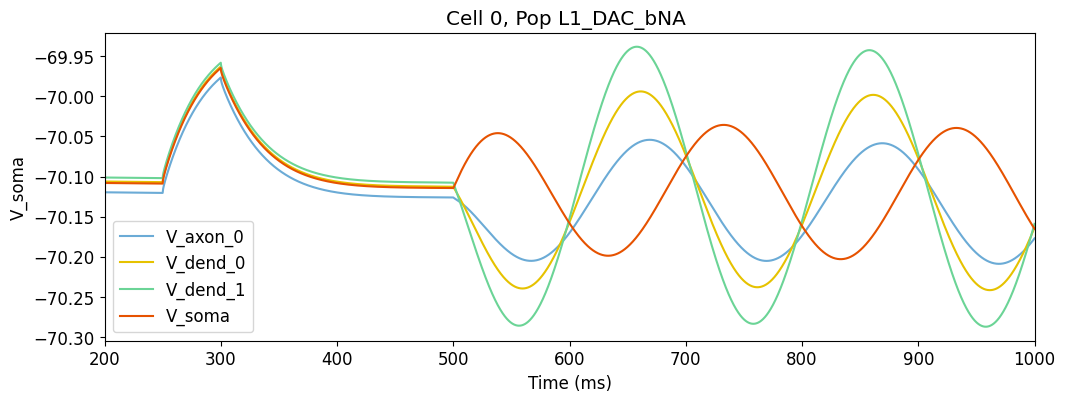

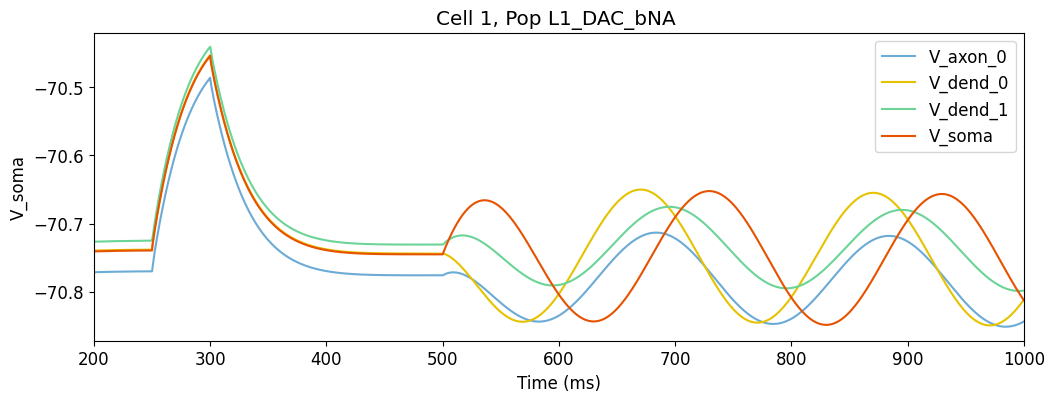

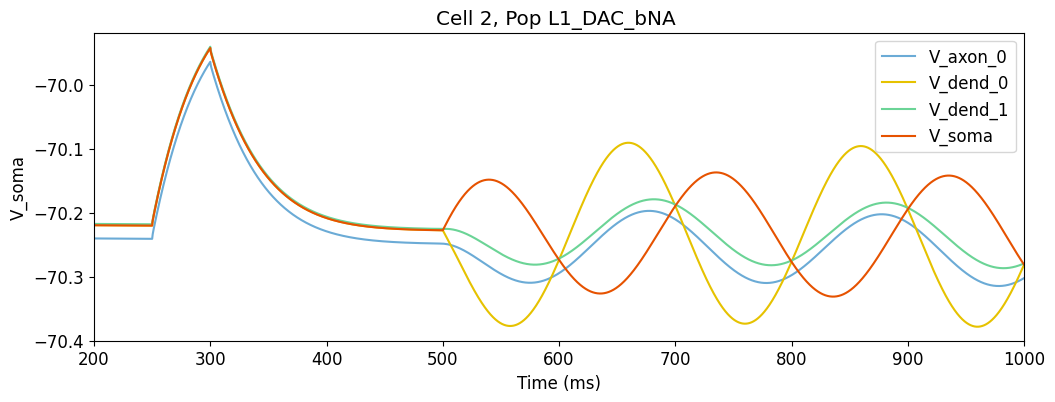

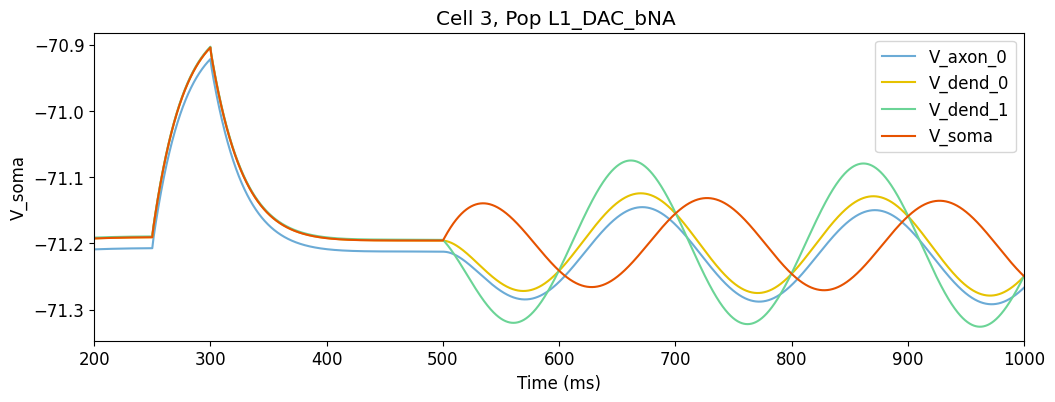

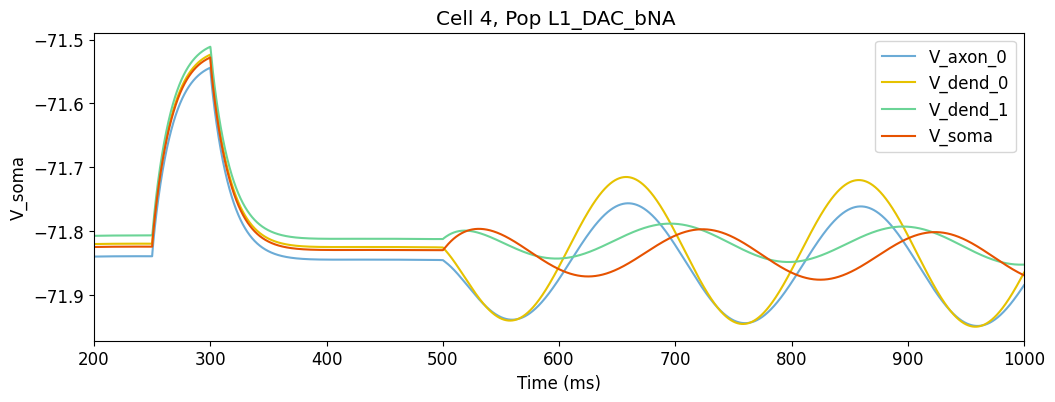

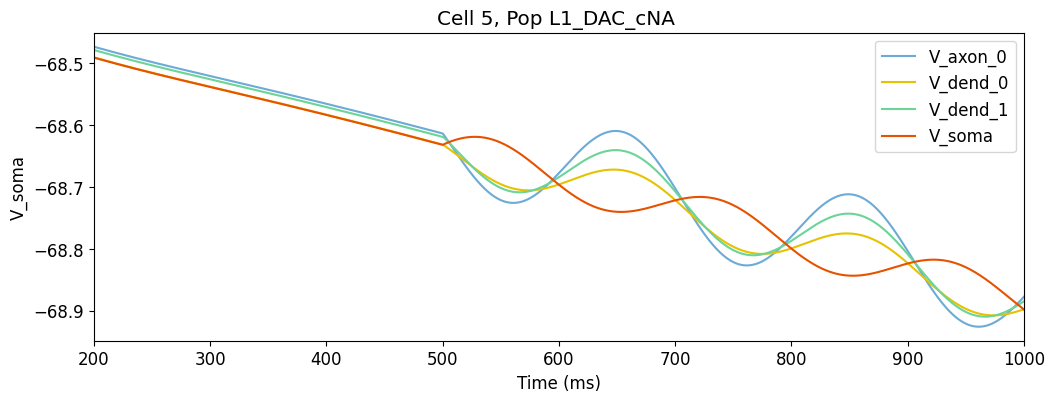

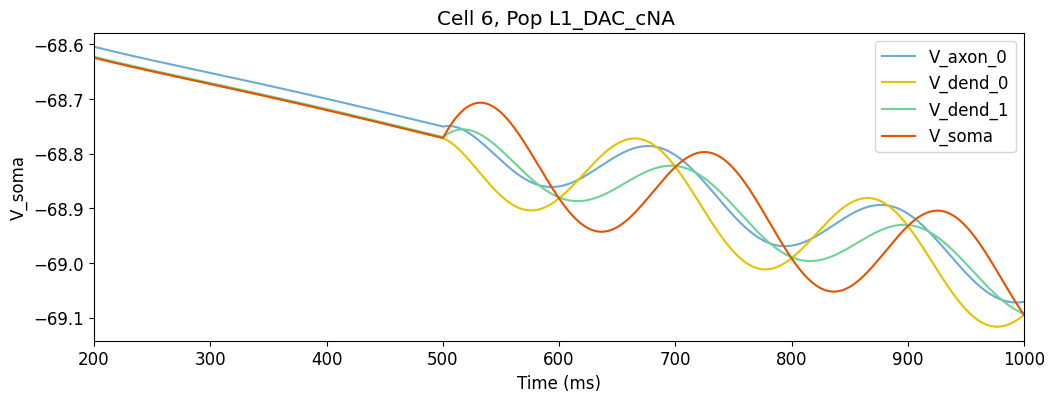

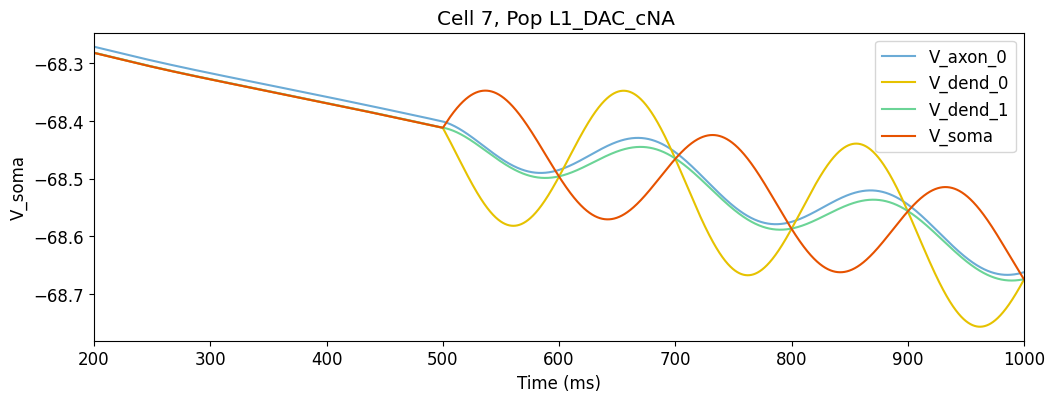

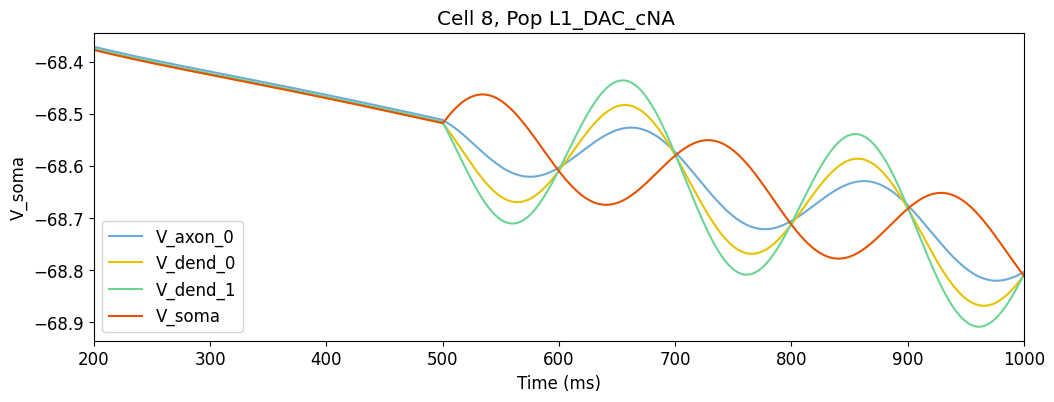

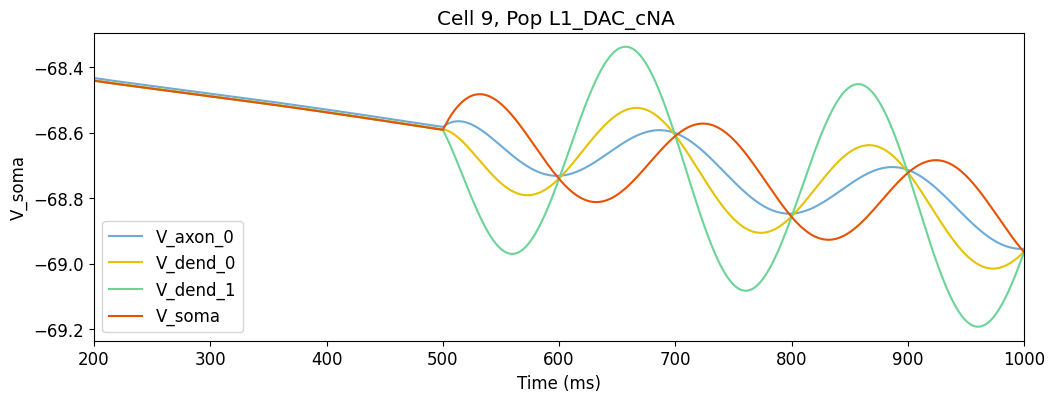

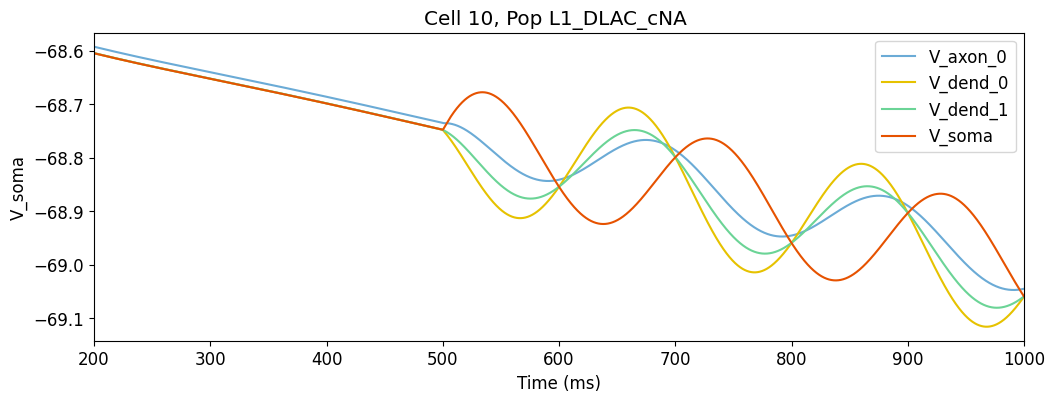

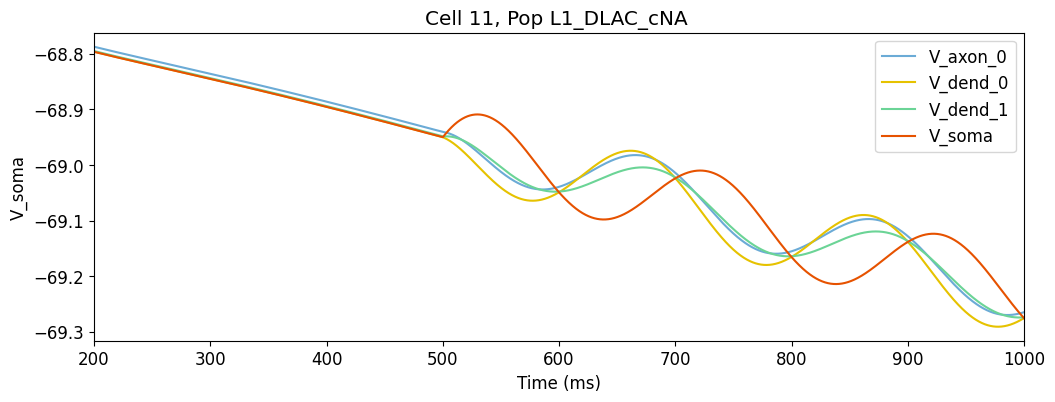

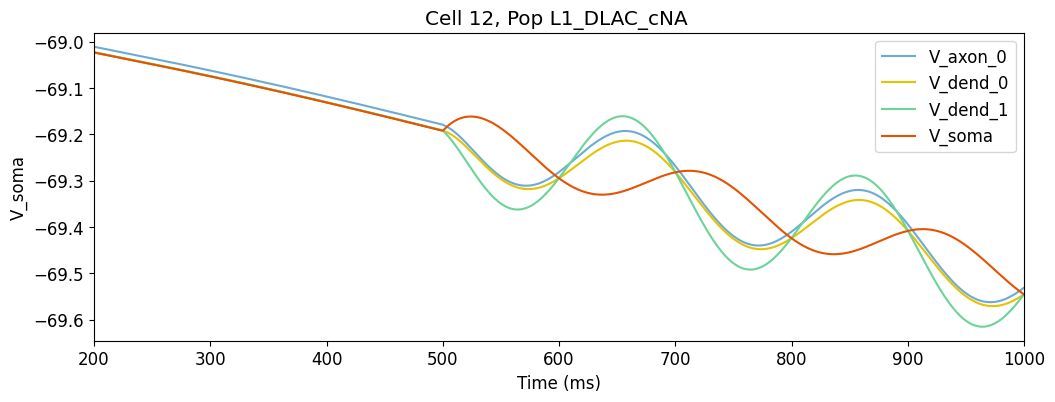

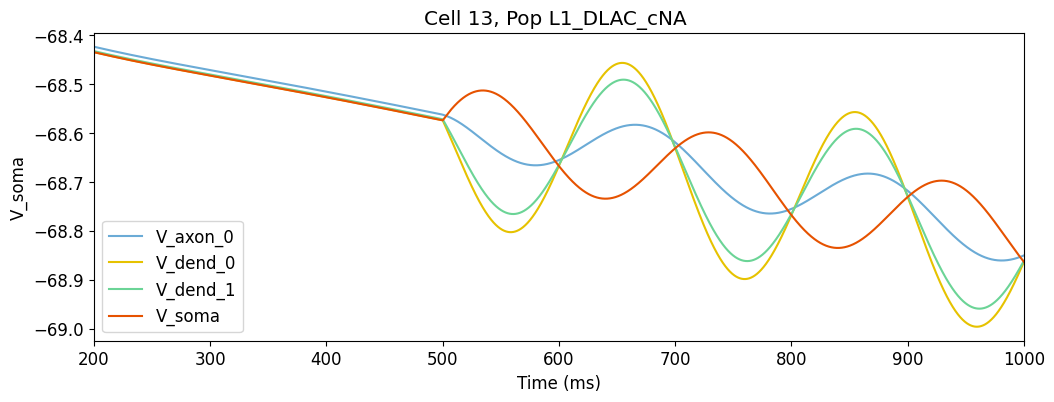

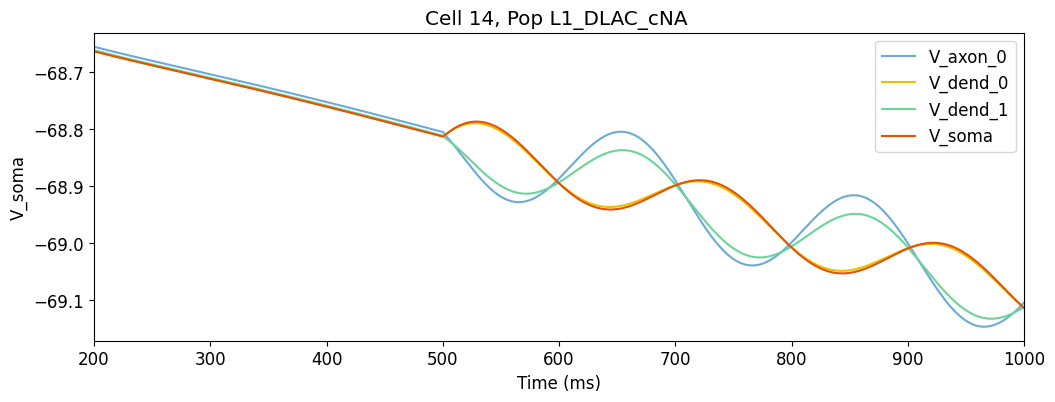

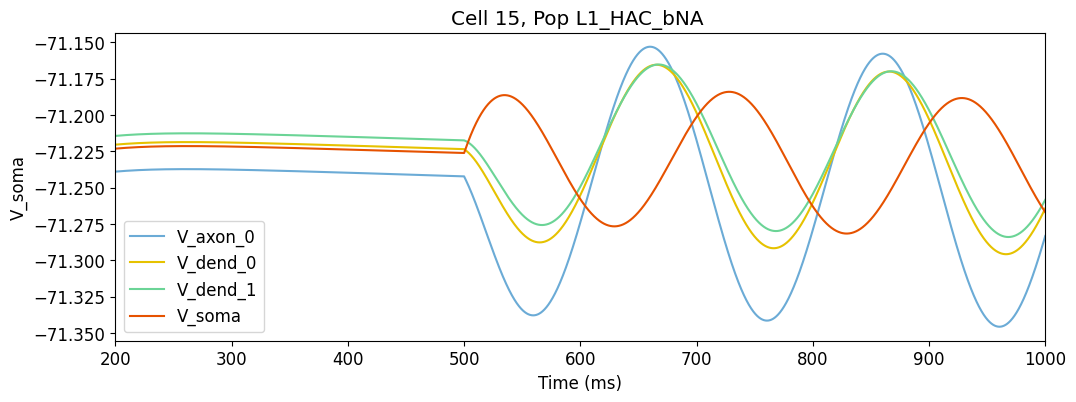

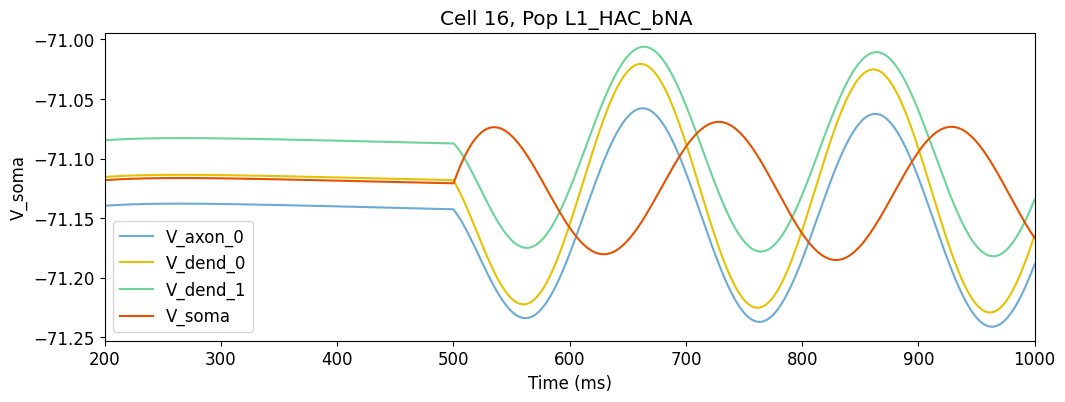

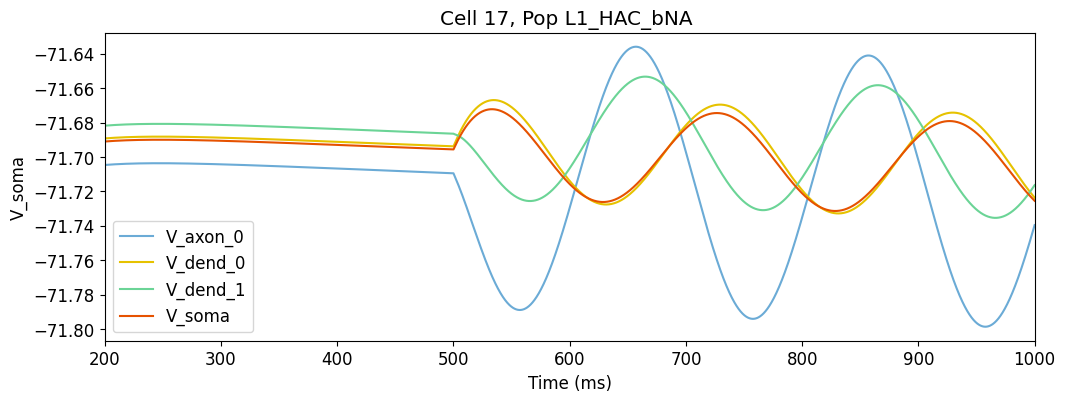

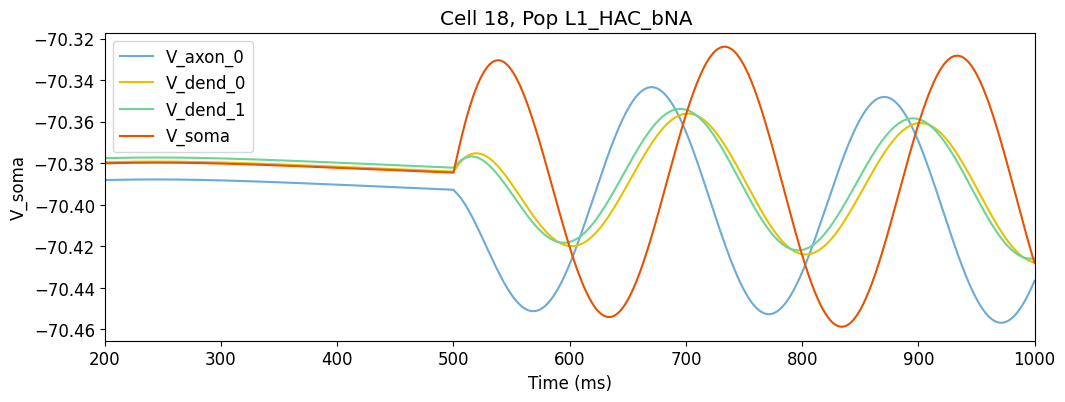

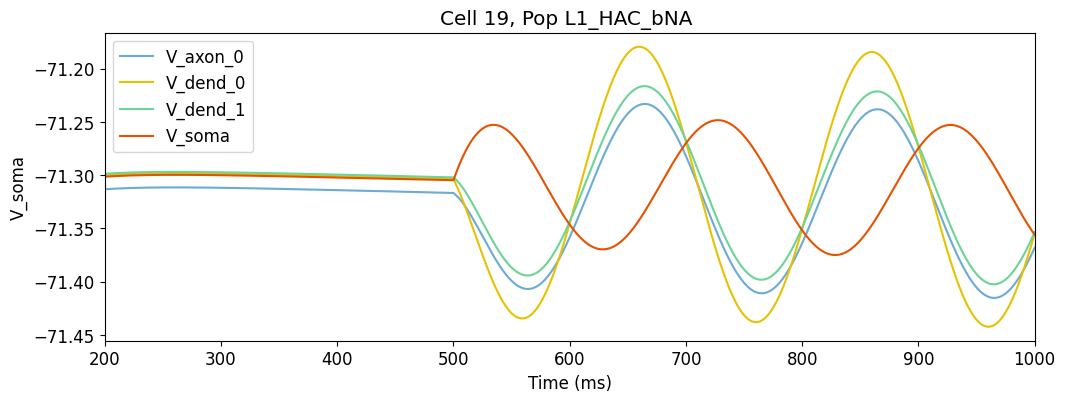

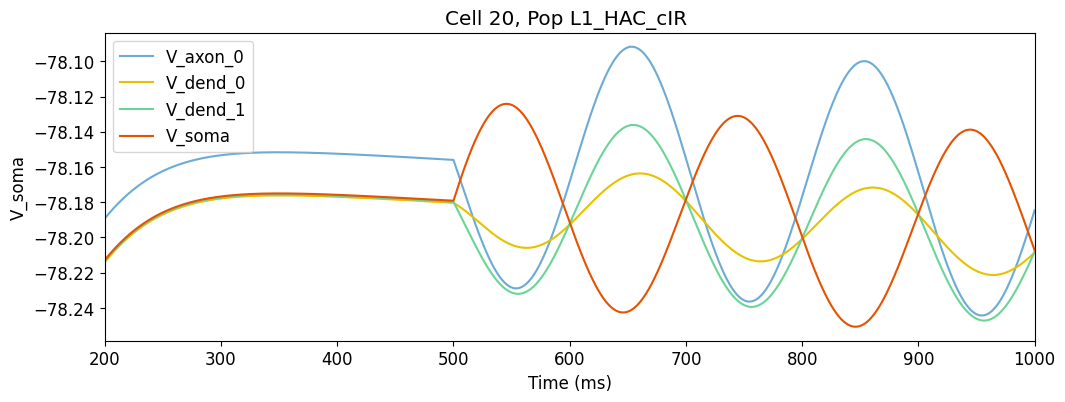

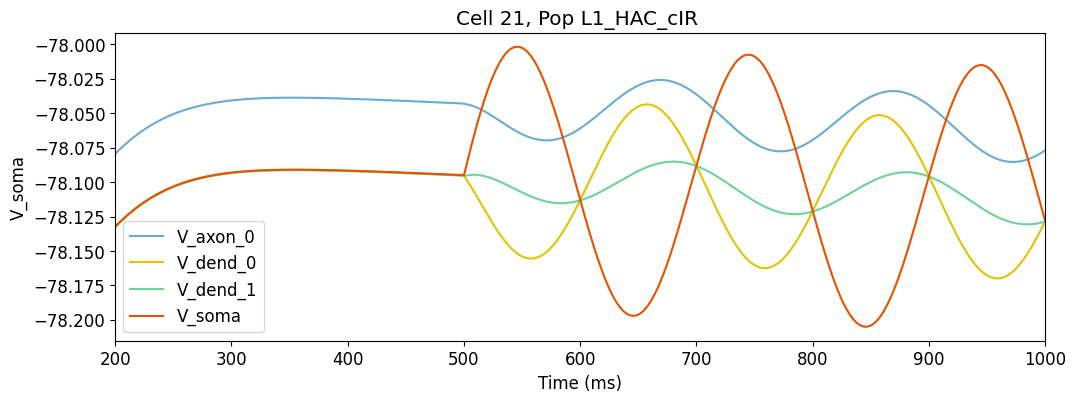

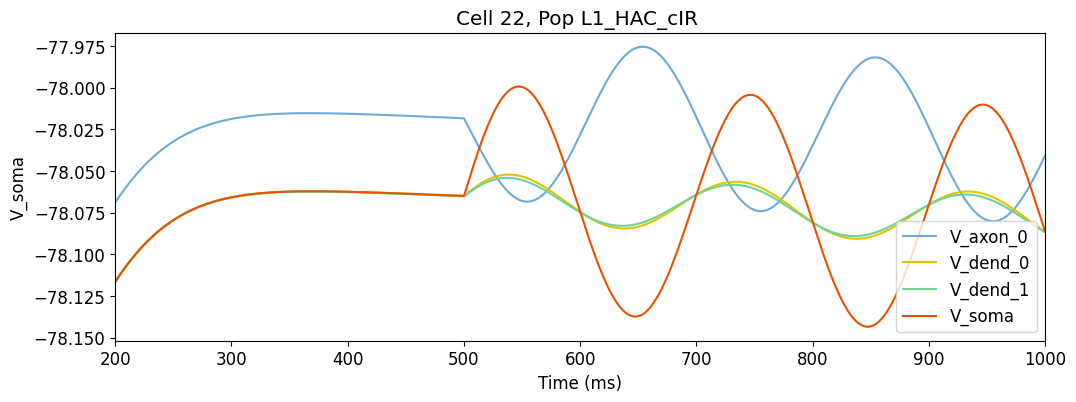

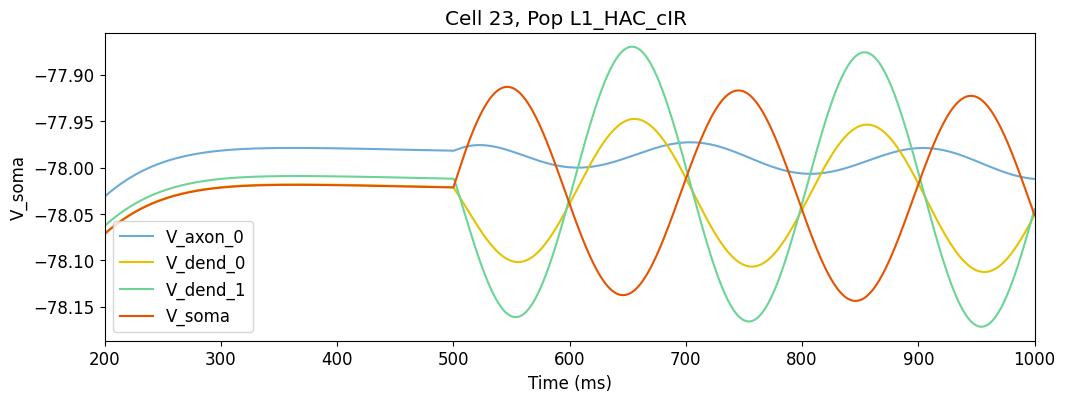

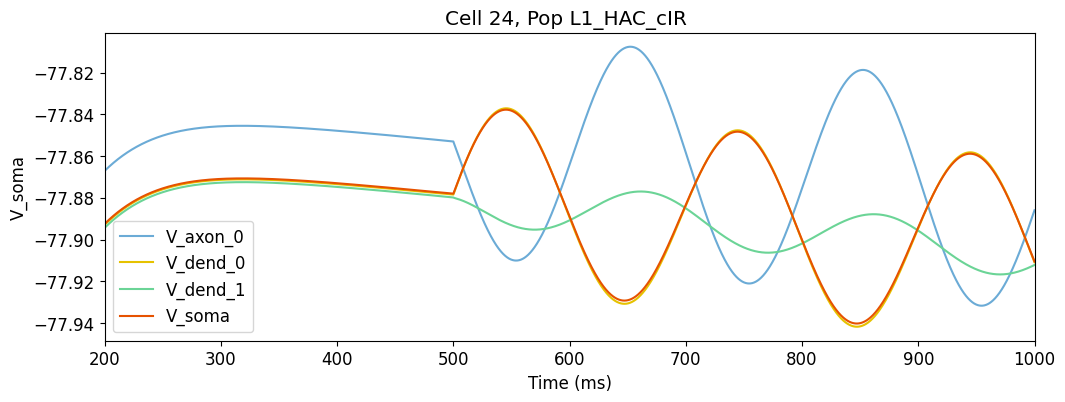

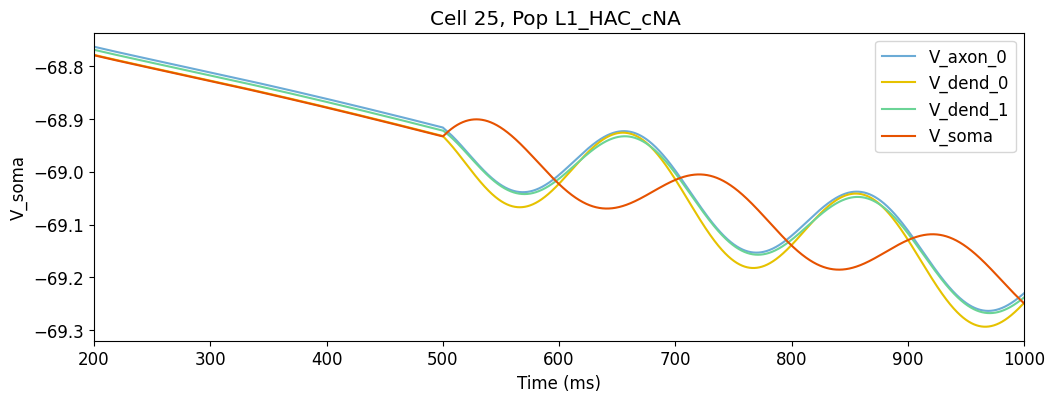

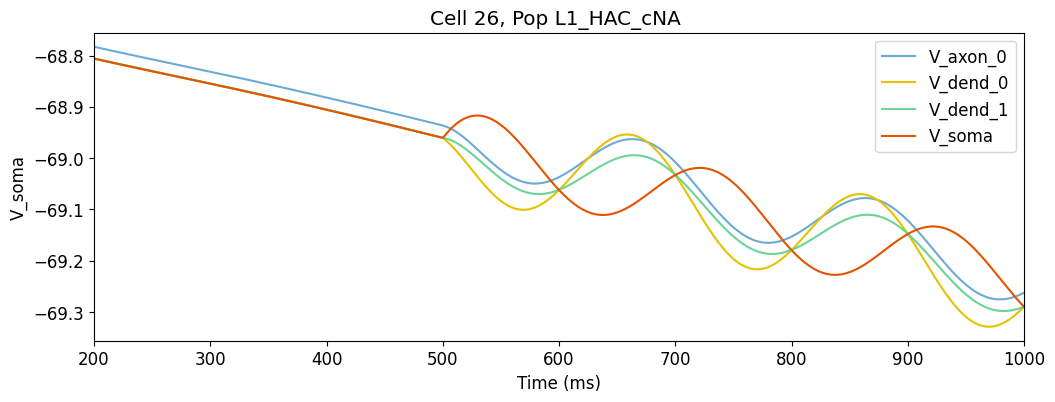

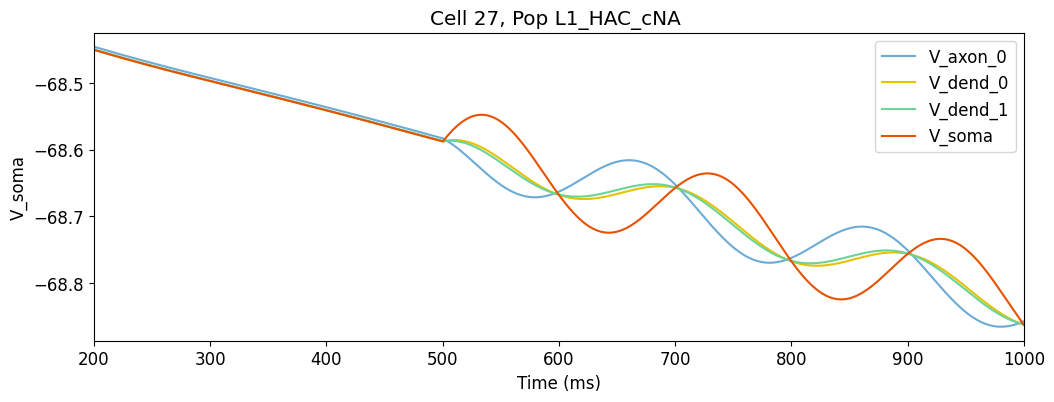

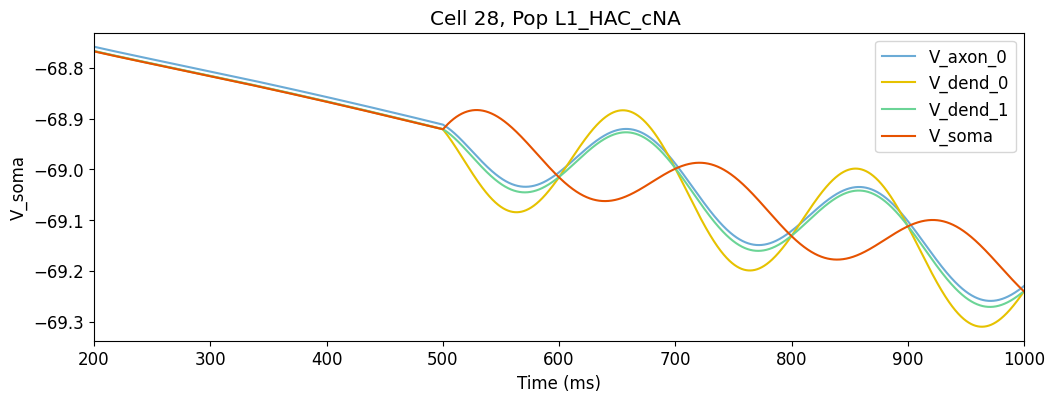

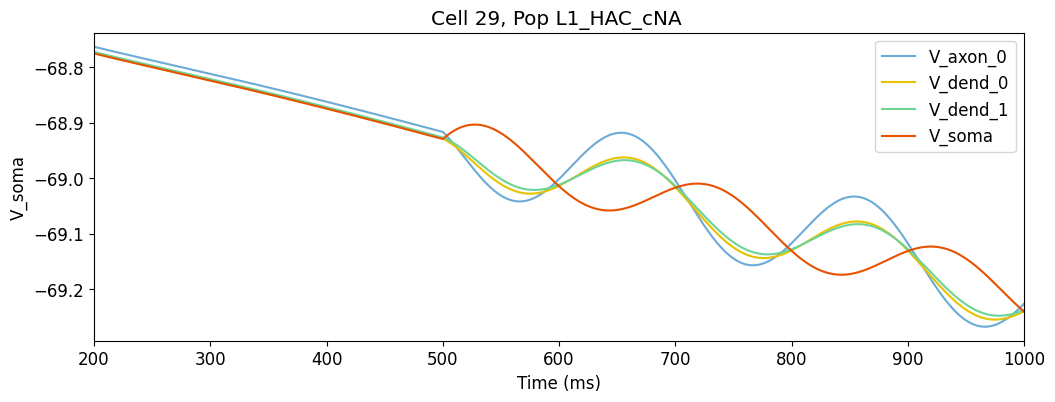

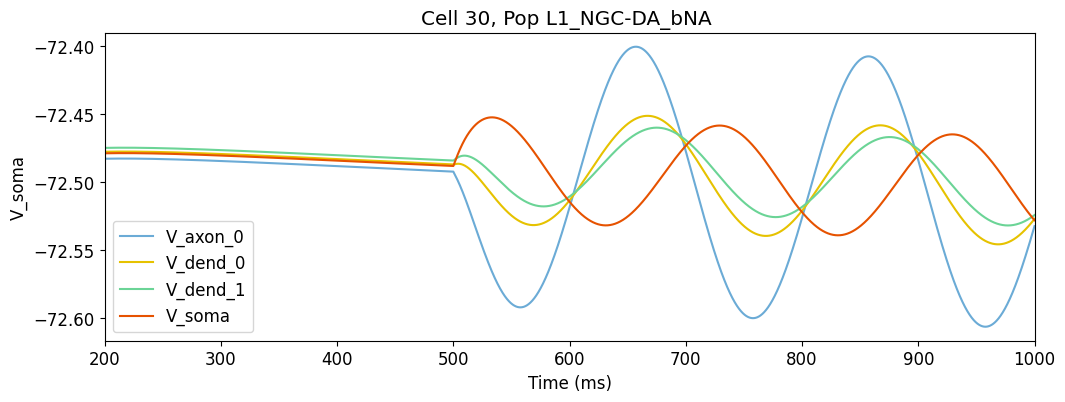

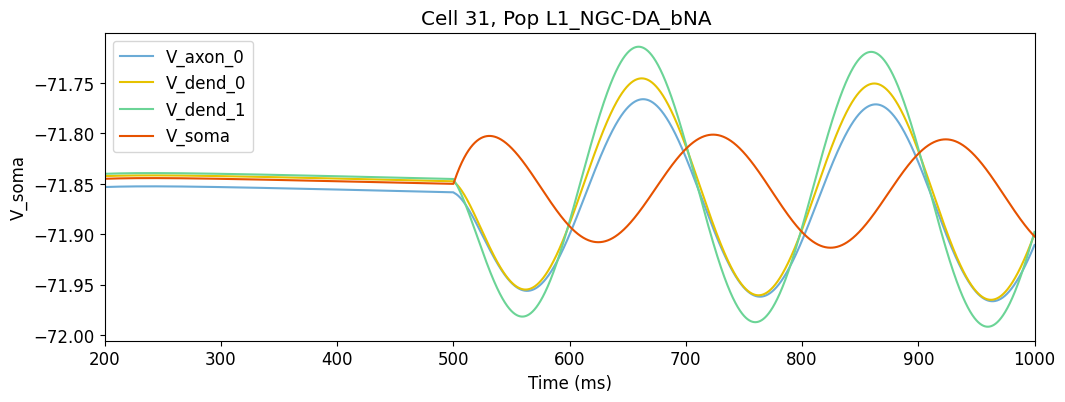

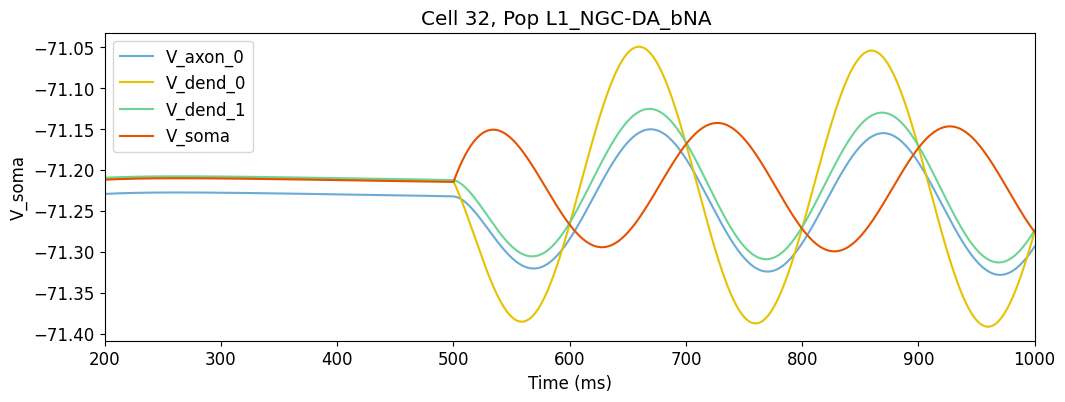

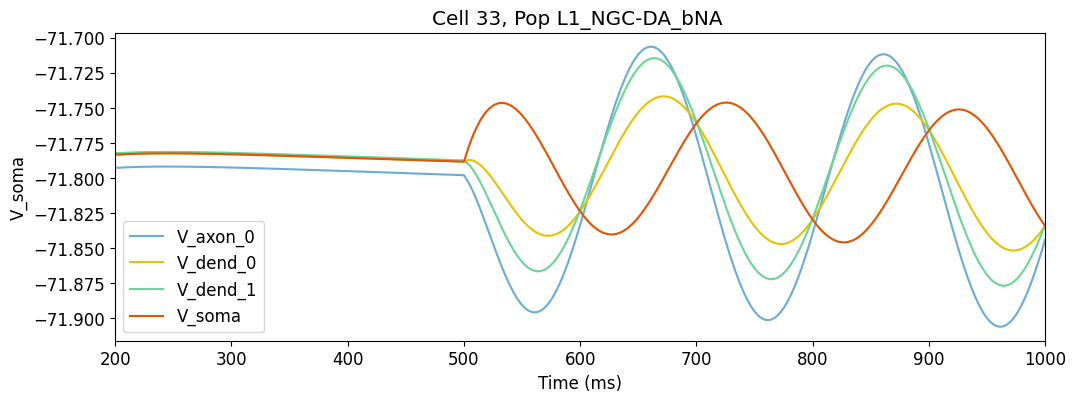

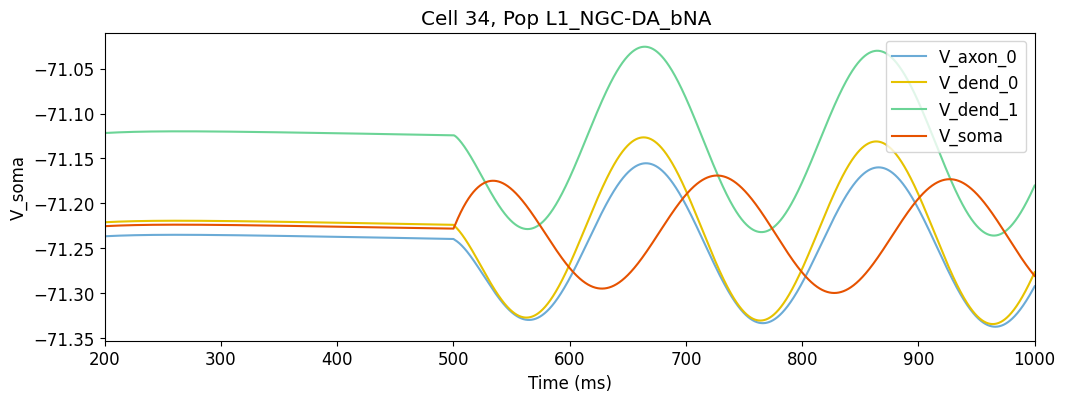

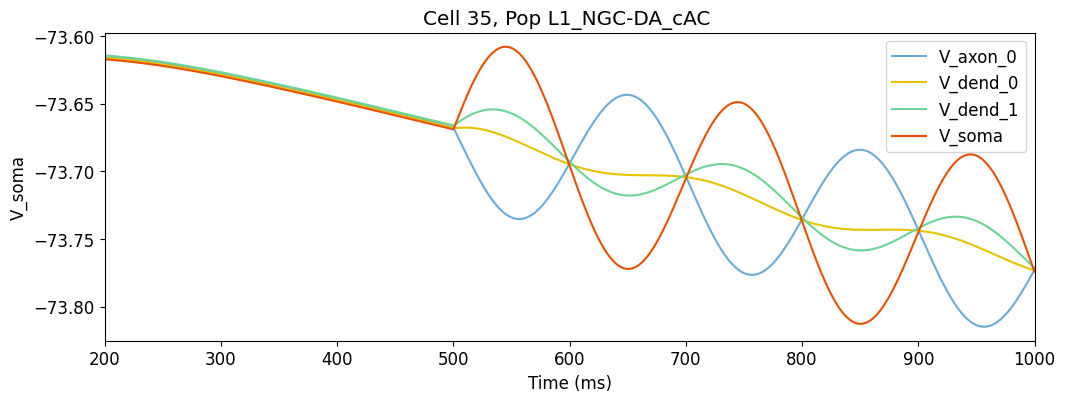

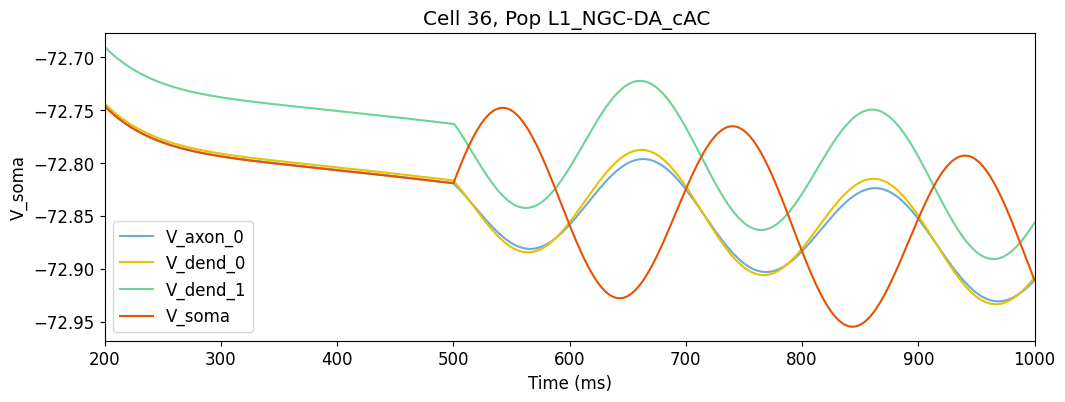

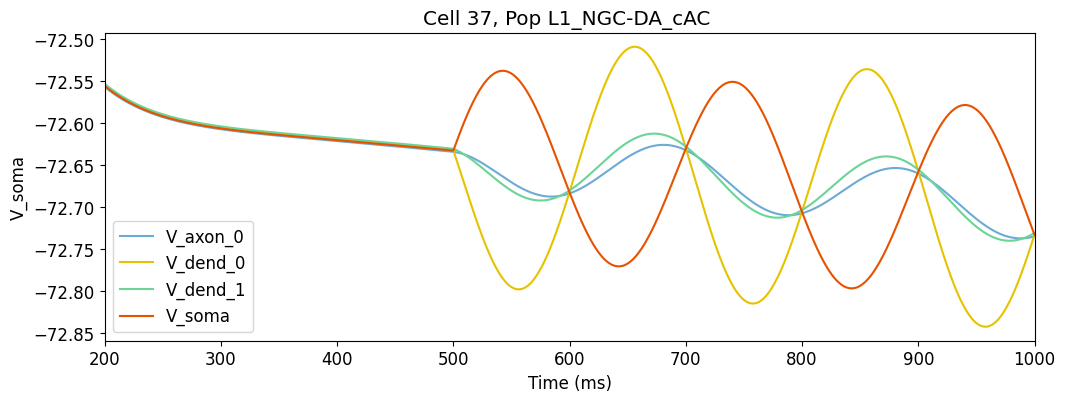

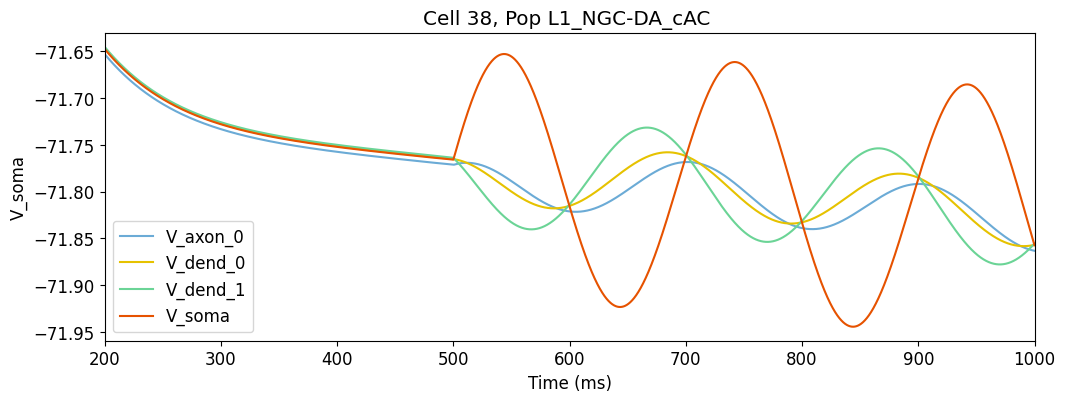

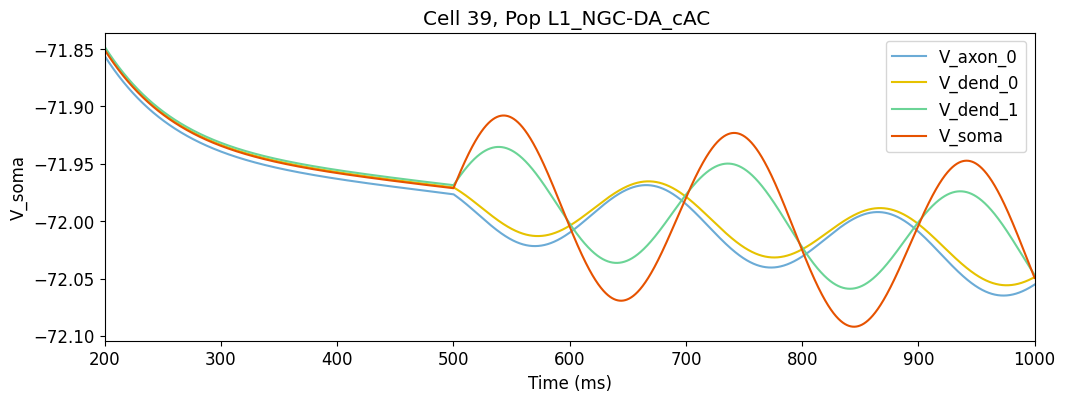

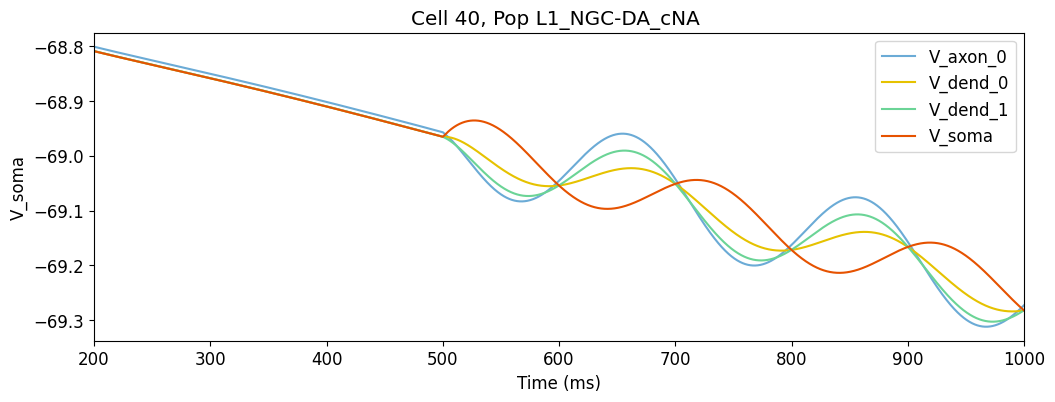

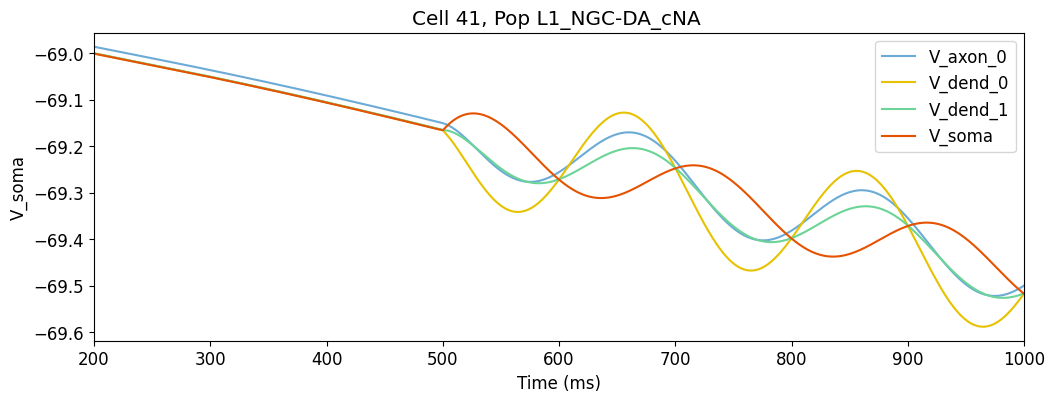

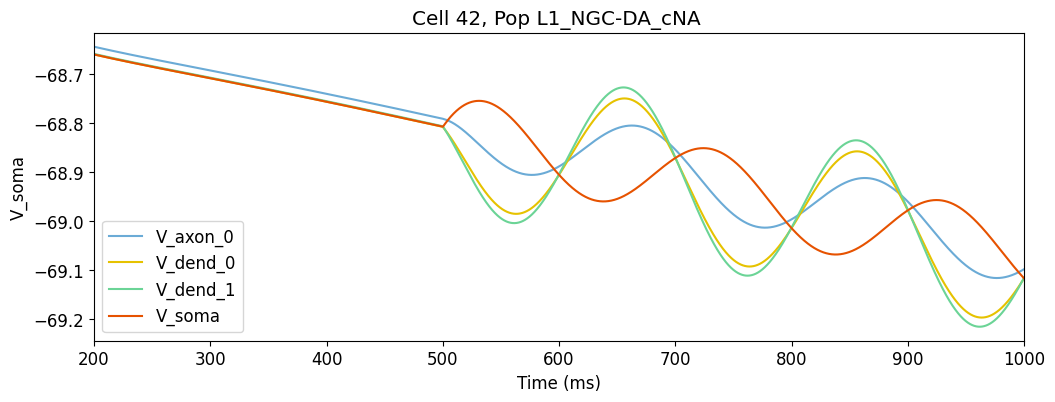

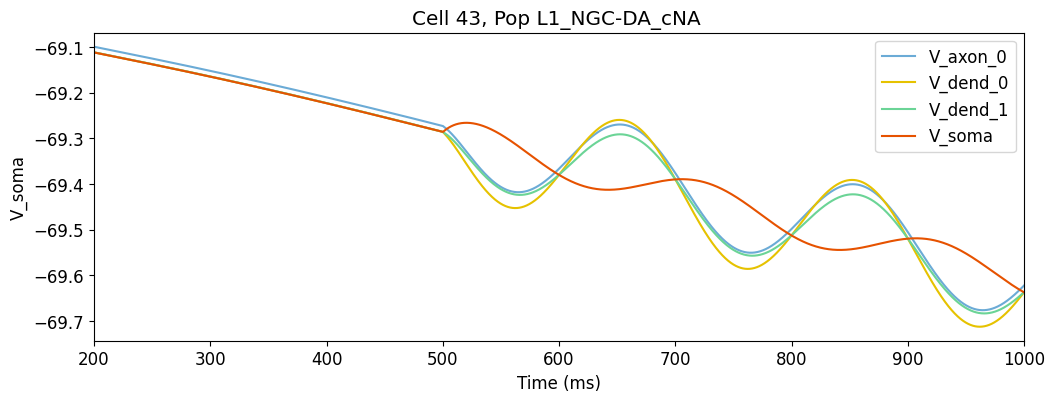

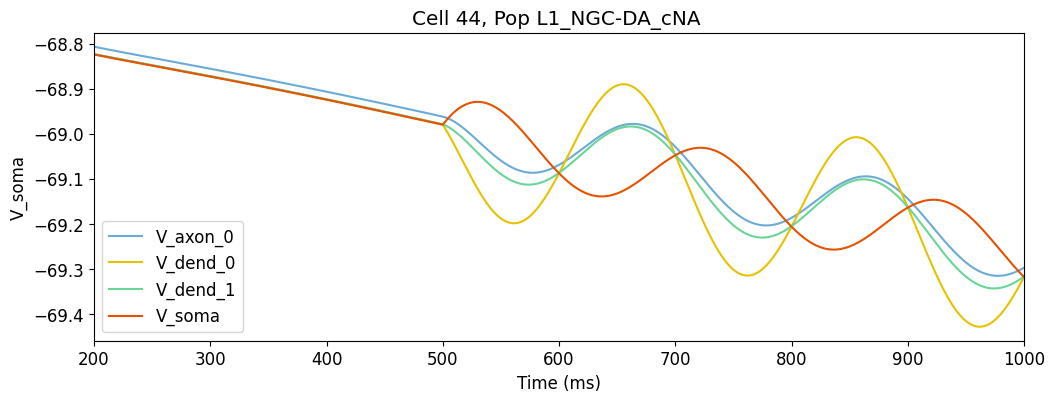

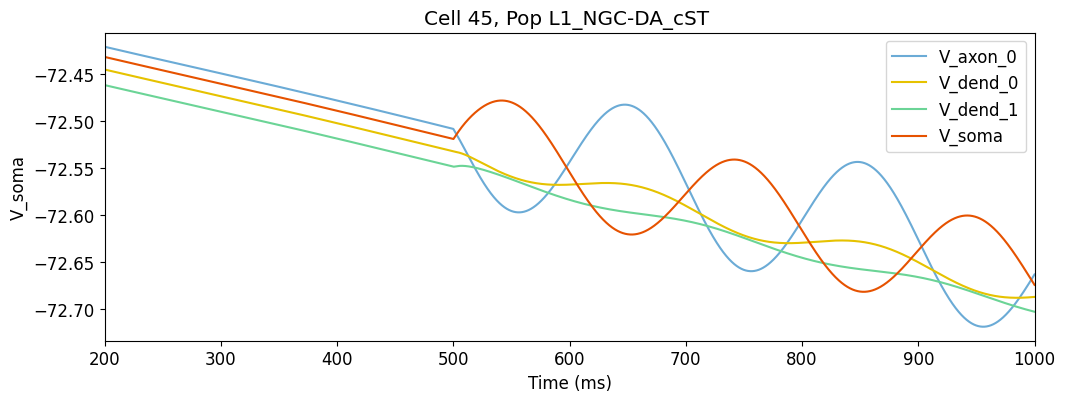

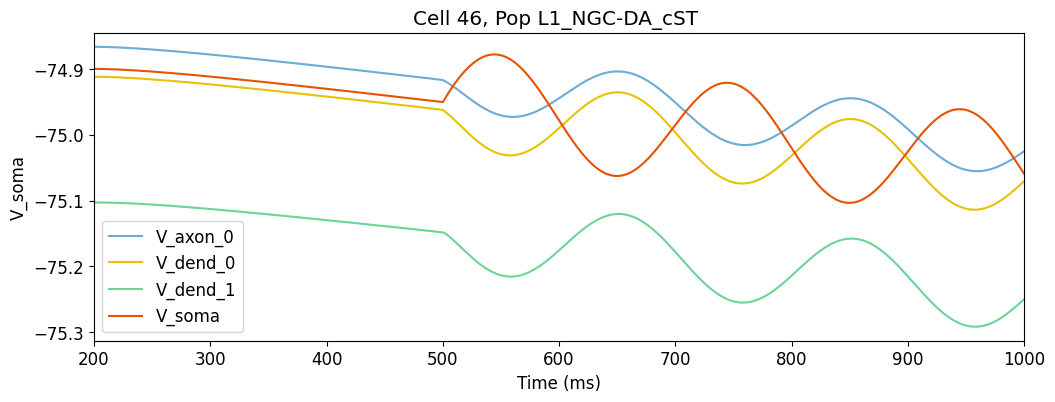

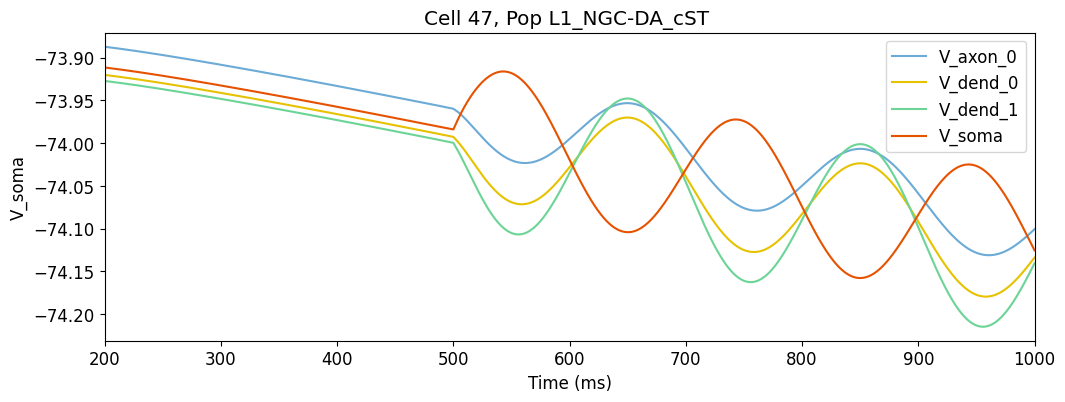

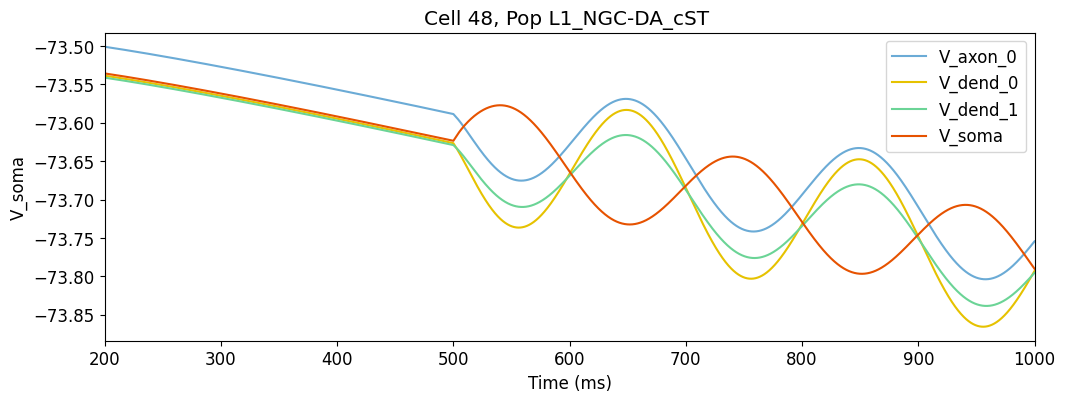

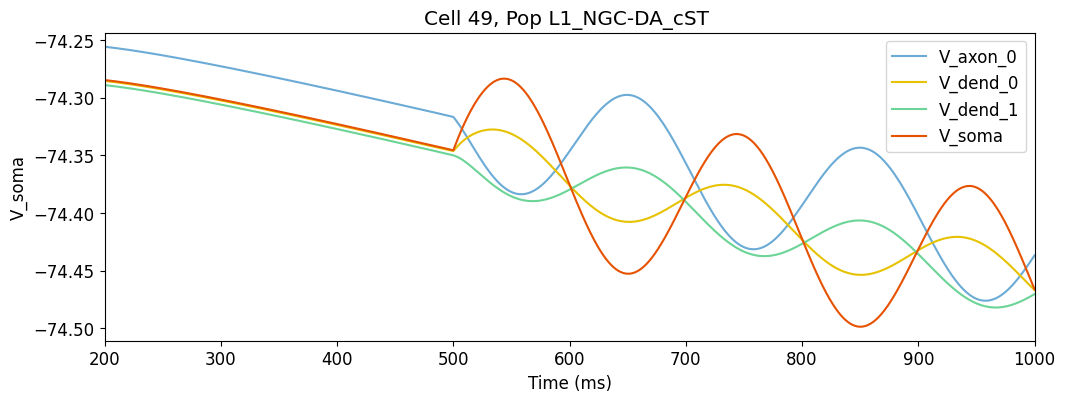

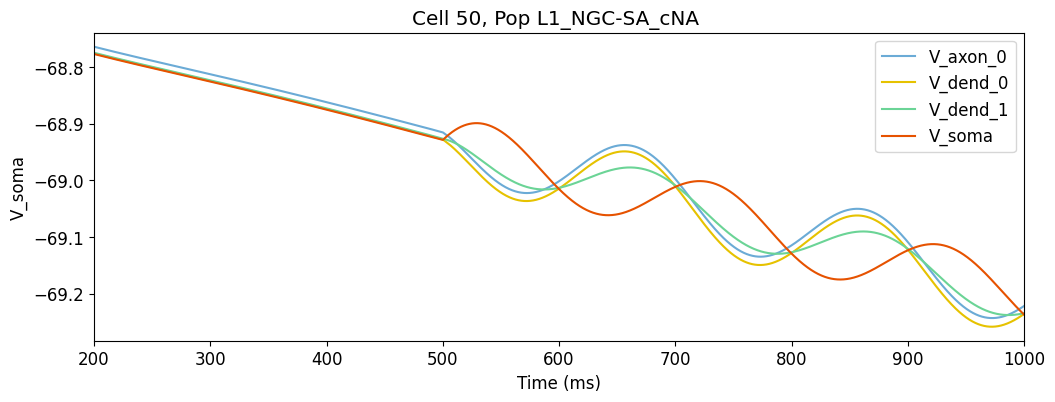

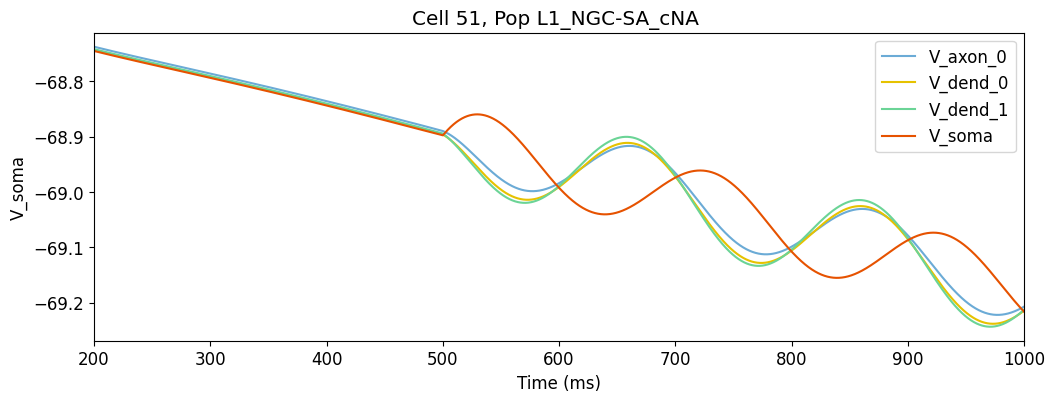

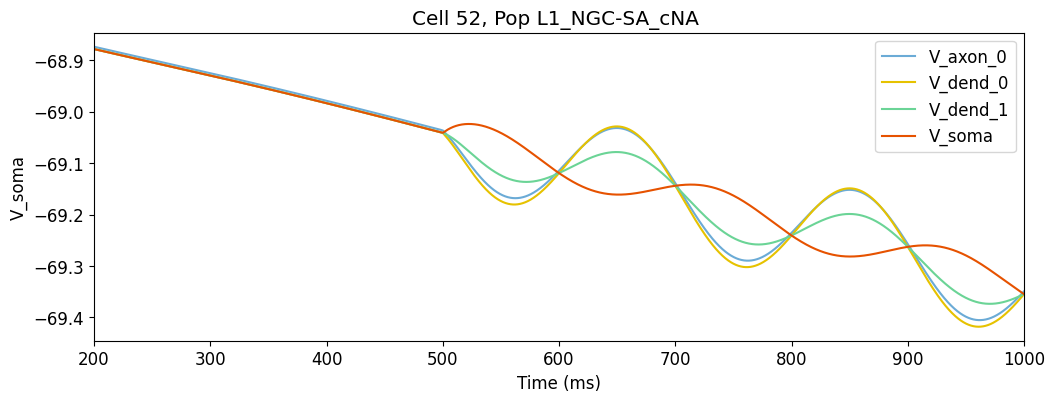

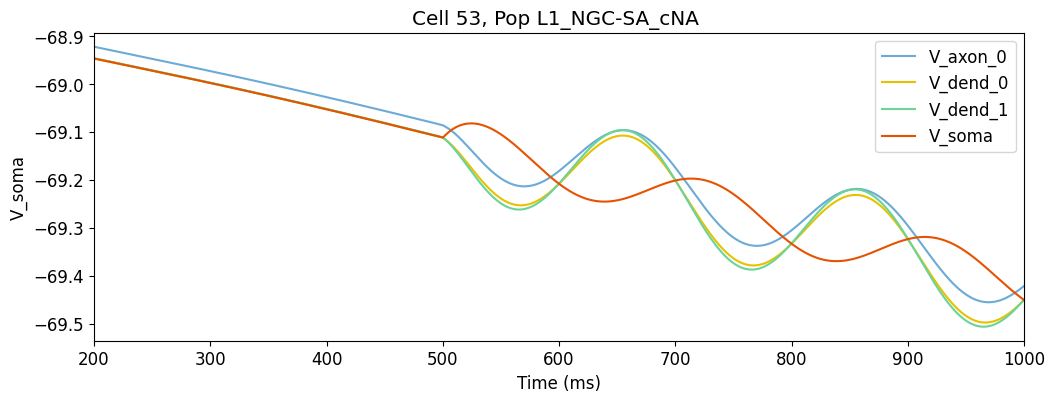

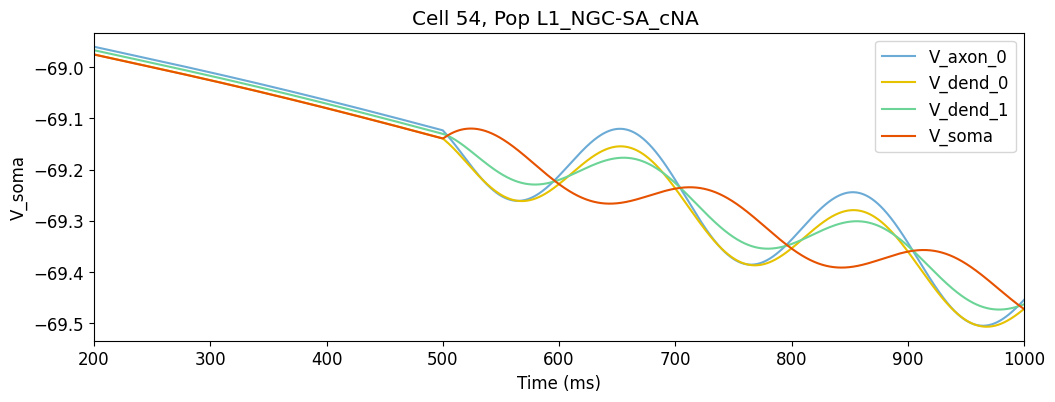

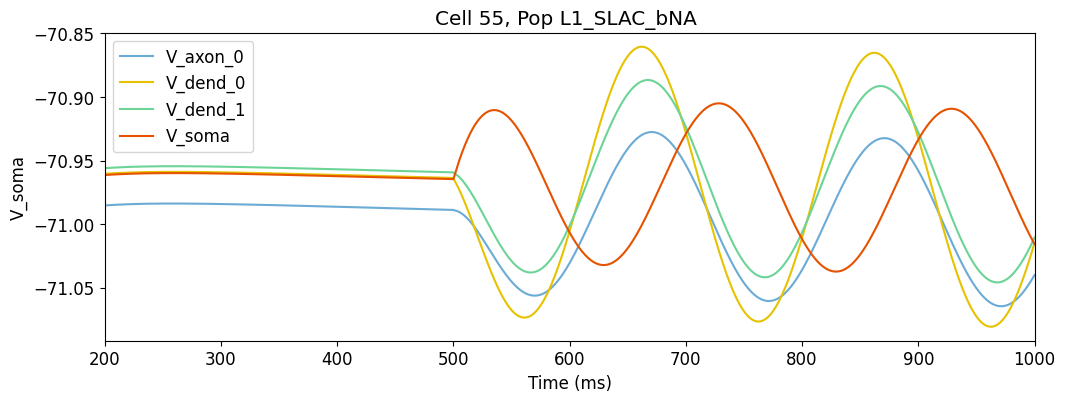

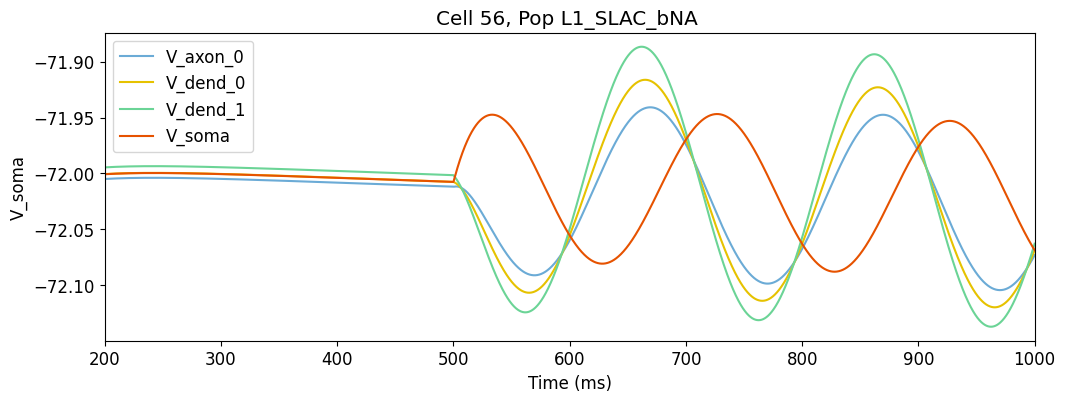

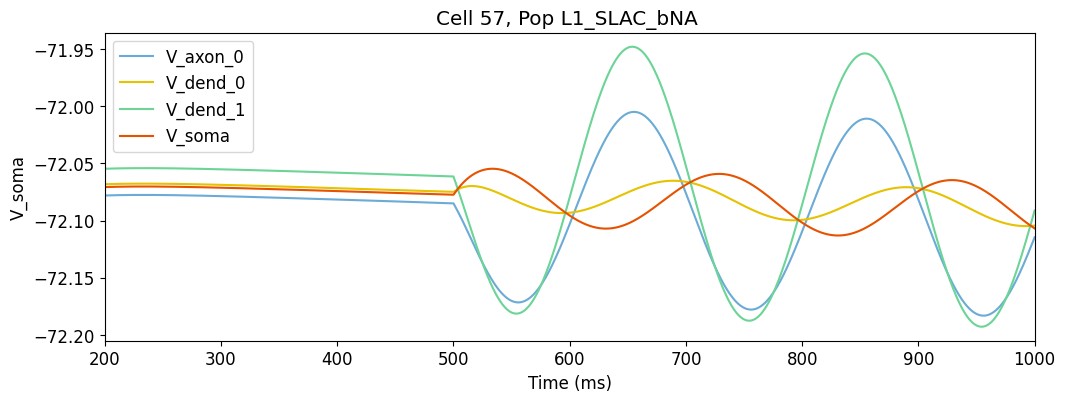

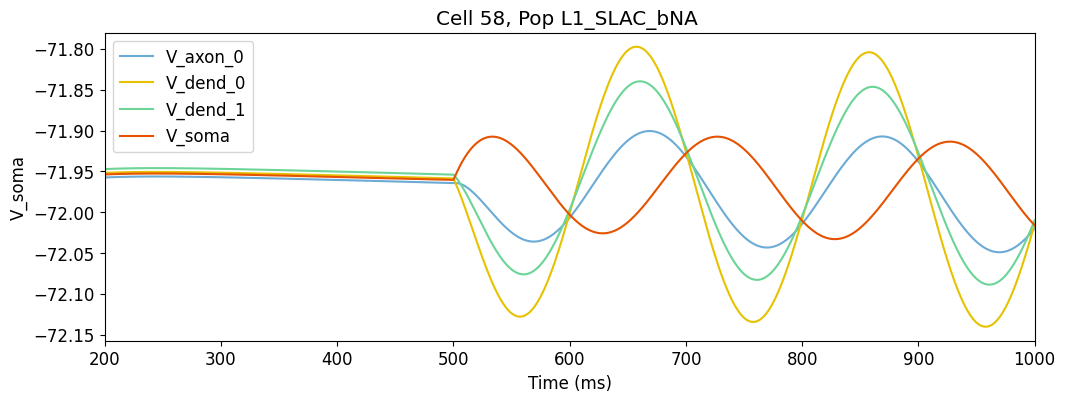

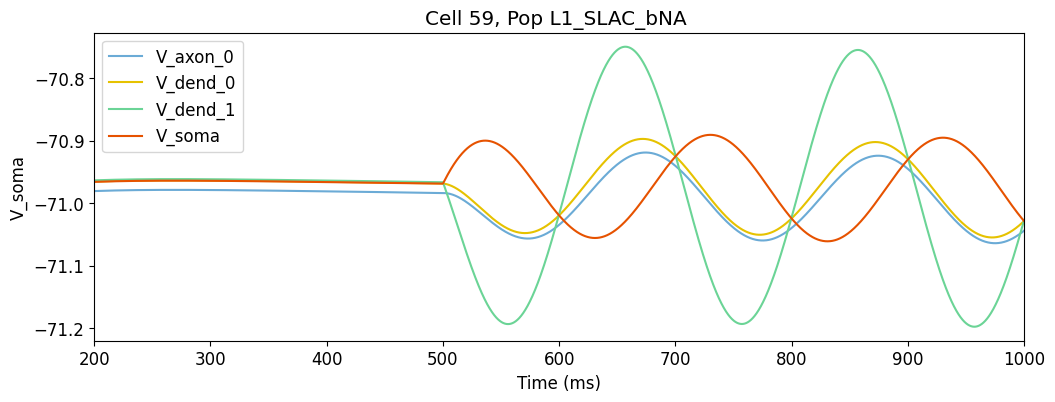

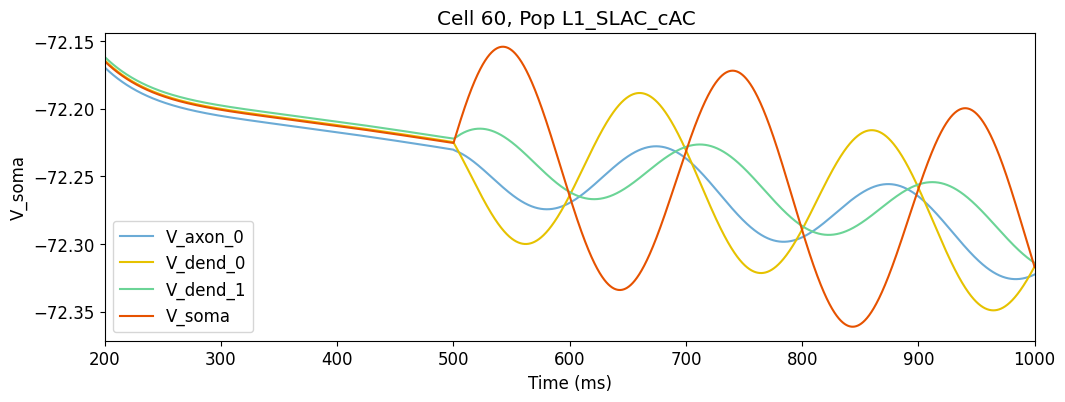

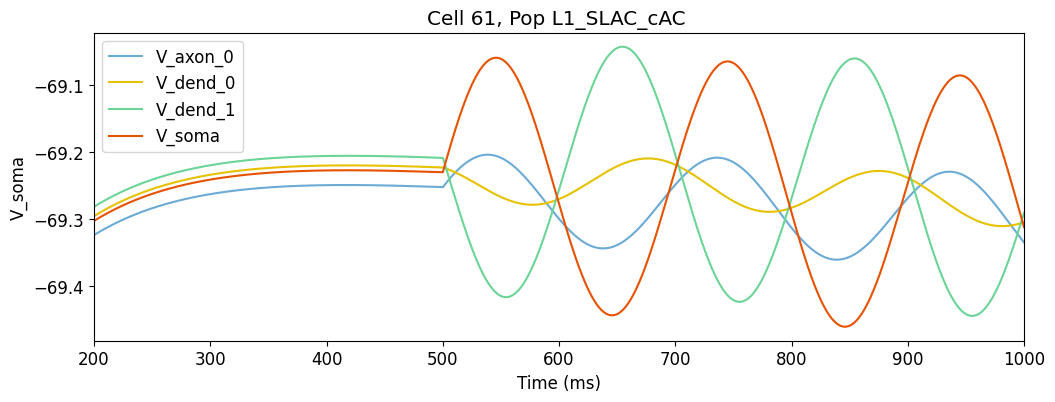

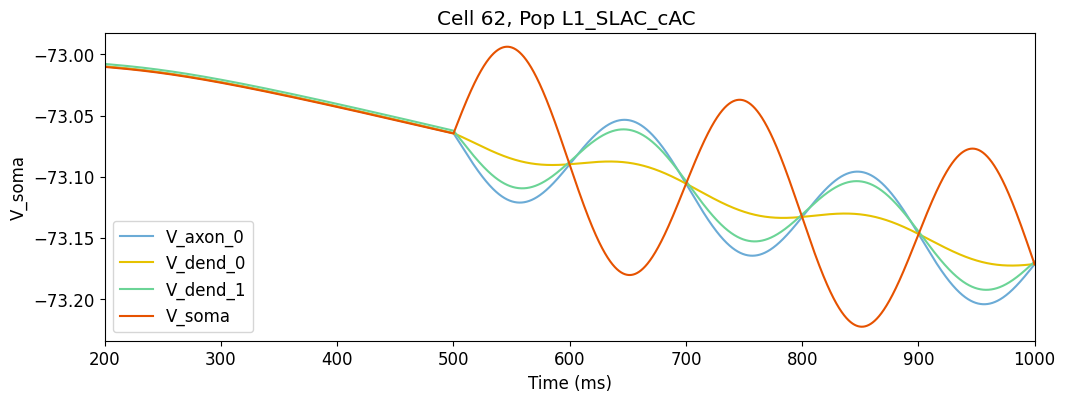

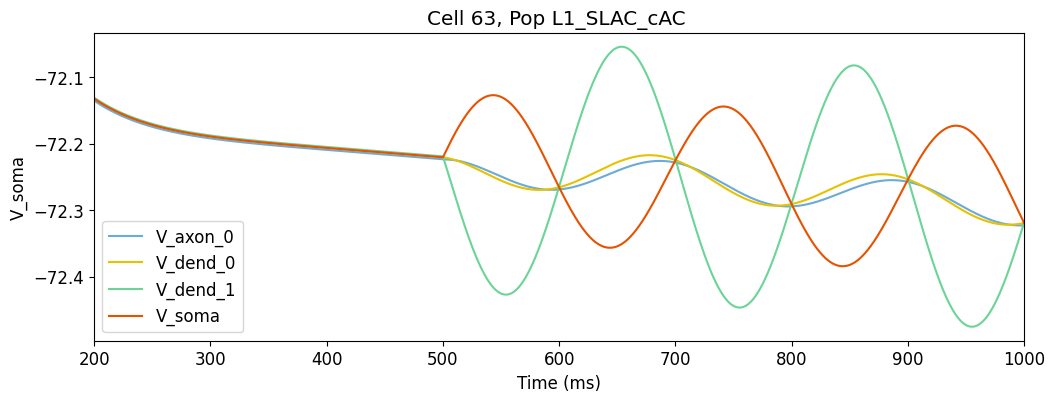

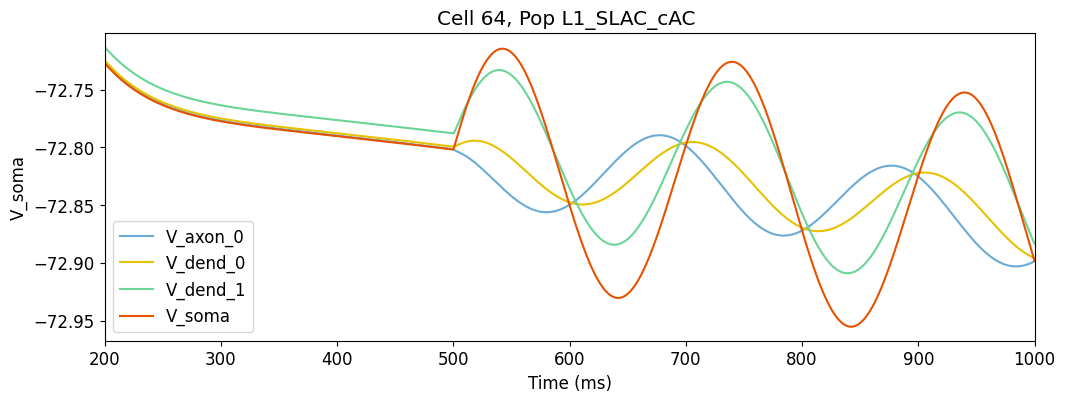

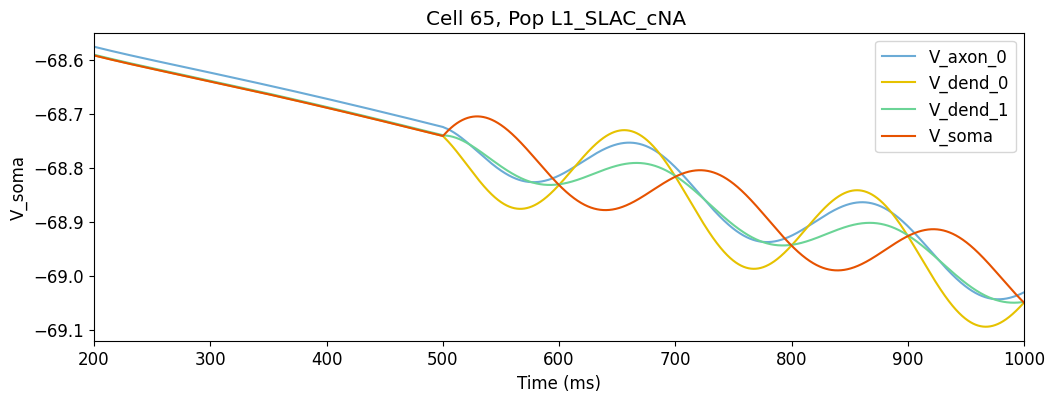

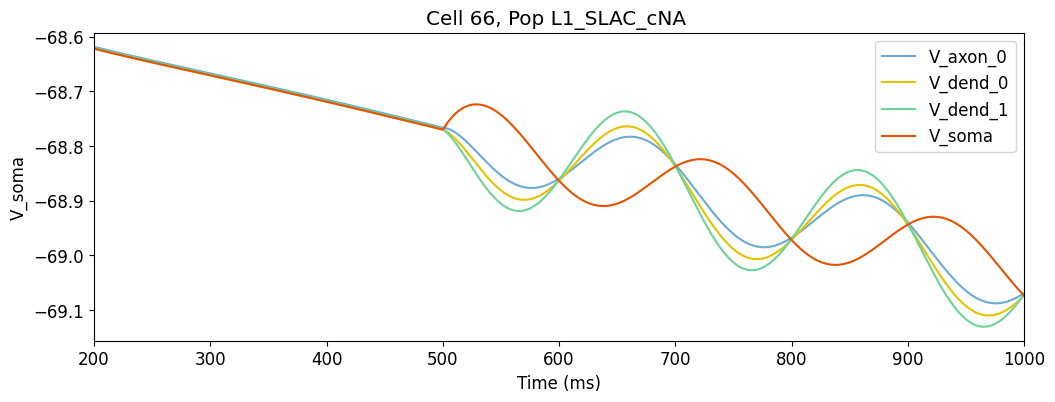

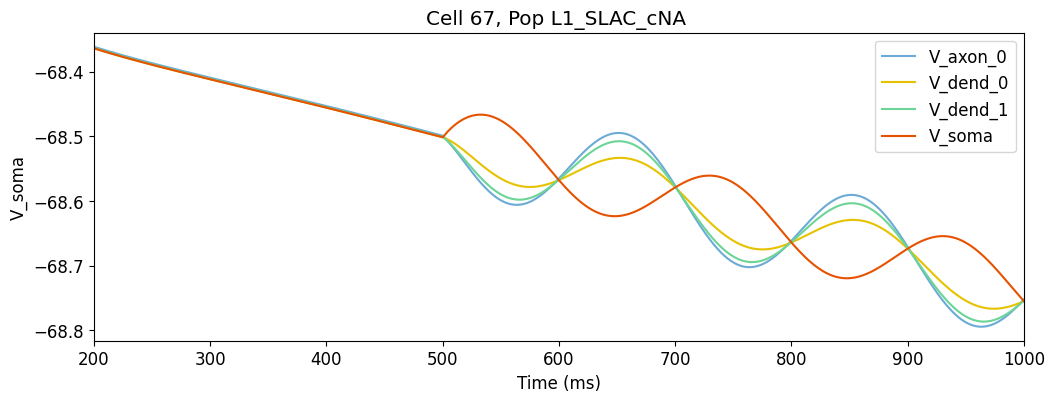

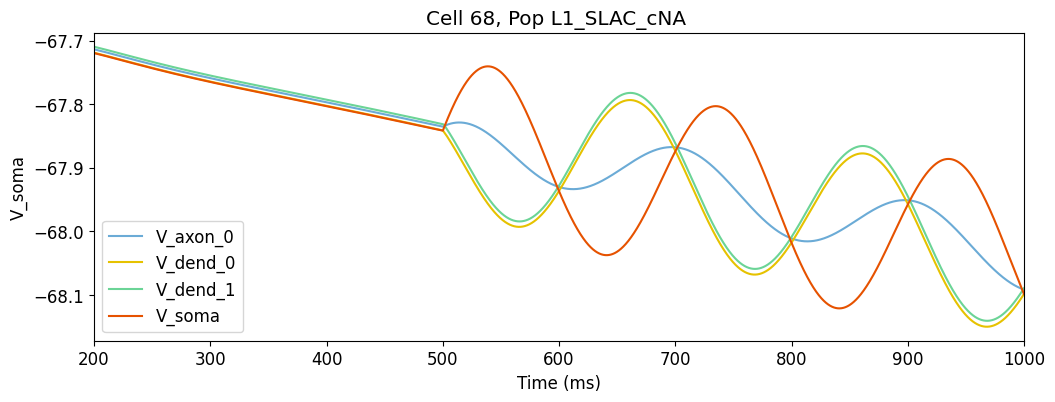

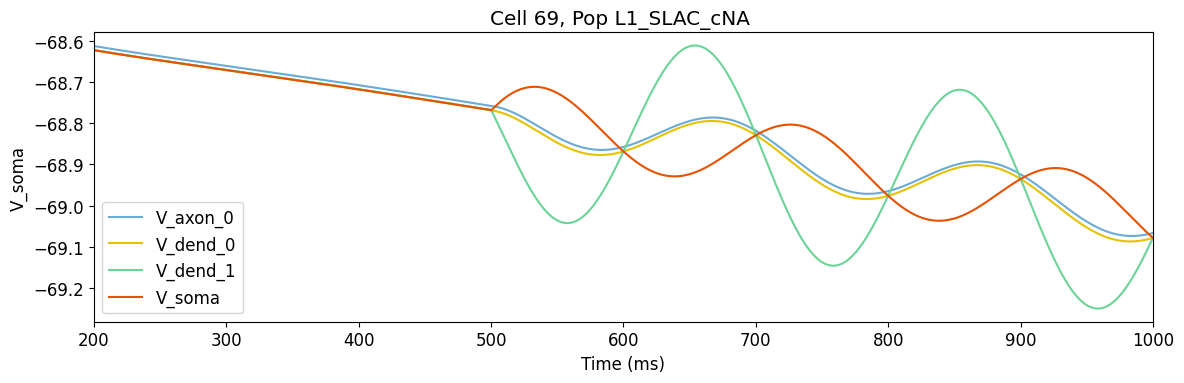

In [6]:
def collect_pt3d(self, section):
        """        collect the pt3d info, for each section
        """
        n3dsec = 0
        r3dsec = np.zeros(3)
        for sec in [sec for secName, sec in self.secs.items() if section in secName]:
            sec['hObj'].push()
            n3d = int(neuron.h.n3d())  # get number of n3d points in each section
            # print("get number of n3d points in each section",n3d)
            r3d = np.zeros((3, n3d))  # to hold locations of 3D morphology for the current section
            n3dsec += n3d

            for i in range(n3d):
                r3dsec[0] += neuron.h.x3d(i)
                r3dsec[1] += neuron.h.y3d(i)
                r3dsec[2] += neuron.h.z3d(i)
            
            neuron.h.pop_section()

        r3dsec /= n3dsec
        
        return r3dsec
    
def getSecsPos(self, secList):
        """        Get Secs position
        """
        x3d, y3d, z3d = [], [], []
        
        for secName in secList:
            # print(secName)
            r3dsec = collect_pt3d(self, secName)
            # print(secName, r3dsec)
            
            x3d.append(r3dsec[0])
            y3d.append(r3dsec[1])
            z3d.append(r3dsec[2])
            
        return x3d, y3d, z3d
    
def insert_v_ext(self, v_ext, t_ext):

    self.t_ext = neuron.h.Vector(t_ext)
    self.v_ext = []
    for v in v_ext:
        self.v_ext.append(neuron.h.Vector(v))
    
    # play v_ext into e_extracellular reference
    i = 0
    for secName, sec in self.secs.items(): 
        # print(secName,i)
        for seg in sec['hObj']:
            self.v_ext[i].play(seg._ref_e_extracellular, self.t_ext)
        i += 1
  
def make_extracellular_stimuli(acs_params, self, secList):
    """ Function to calculate and apply external potential """
    x0, y0, z0 = acs_params['position']
    ext_field = np.vectorize(lambda x, y, z: 1 / (4 * np.pi *
                            (acs_params['sigma'] * 
                            np.sqrt((x0 - x)**2 + (y0 - y)**2 + (z0 - z)**2) + skull_attenuation)))

    stimstart = acs_params['stimstart']
    stimend = acs_params['stimend']
    stimdif = stimend-stimstart

    # MAKING THE EXTERNAL FIELD
    n_tsteps = int(stimdif / cfg.dt + 1)
    n_start = int(stimstart/cfg.dt)
    n_end = int(stimend/cfg.dt + 1)
    t = np.arange(start=n_start, stop=n_end) * cfg.dt
    pulse = acs_params['amp'] * 1000. * \
        np.sin(2 * np.pi * acs_params['frequency'] * t / 1000)

    totnsegs = len(secList)    
    v_cell_ext = np.zeros((totnsegs, n_tsteps))    
    v_cell_ext[:, :] = ext_field(getSecsPos(metype,secList)[0], -1*np.array(getSecsPos(metype, secList)[1]), 
                                 getSecsPos(metype,secList)[2]).reshape(totnsegs, 1) * pulse.reshape(1, n_tsteps)
    
    insert_v_ext(self, v_cell_ext, t)

    return v_cell_ext, self


# The parameters of the extracellular point current source
acs_params = {'position': [0.0, -1710.0, 0.0],  # um # y = [pia, bone]
              'amp': 50.,  # uA,
              'stimstart': 500,  # ms
              'stimend': 1500,  # ms
              'frequency': 5,  # Hz
              'sigma': 0.57  # decay constant S/m
              }

skull_attenuation = 0.01*710 #conductivity of bone(S/m) * thickness of rat skull um

#Add extracellular stim
for c,metype in enumerate(sim.net.cells):
    if 'presyn' not in metype.tags['pop']:
        print("\n", metype.tags)
        # secList = [secs for secs in metype.secs.keys() if "pt3d" in metype.secs[secs]['geom']]
        secList = metype.secLists['all']
        # print(secList)
        v_cell_ext, cell = make_extracellular_stimuli(acs_params, metype,secList)


sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()         			# plot spike raster etc
sim.analysis.plotShape()  

(62, 40001)


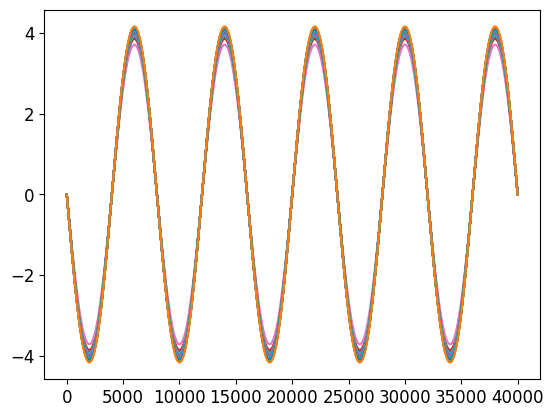

In [7]:
print(np.shape(v_cell_ext))
for v in v_cell_ext:
    plt.plot(v)


 {'cellType': 'L1_DAC_bNA', 'cellModel': 'HH_full', 'pop': 'L1_DAC_bNA', 'xnorm': 0.5870878243802802, 'ynorm': 0.07390450293666112, 'znorm': 0.8430329659561682, 'x': 58.70878243802802, 'y': 7.390450293666112, 'z': 84.30329659561681, 'fraction': 0.0}

 {'cellType': 'L1_DAC_bNA', 'cellModel': 'HH_full', 'pop': 'L1_DAC_bNA', 'xnorm': 0.6774748926971434, 'ynorm': 0.018009485413318153, 'znorm': 0.8995818001949194, 'x': 67.74748926971435, 'y': 1.8009485413318154, 'z': 89.95818001949193, 'fraction': 0.2}

 {'cellType': 'L1_DAC_bNA', 'cellModel': 'HH_full', 'pop': 'L1_DAC_bNA', 'xnorm': 0.07923239666095228, 'ynorm': 0.020236006196300498, 'znorm': 0.3205970818631164, 'x': 7.923239666095228, 'y': 2.0236006196300496, 'z': 32.05970818631164, 'fraction': 0.4}

 {'cellType': 'L1_DAC_bNA', 'cellModel': 'HH_full', 'pop': 'L1_DAC_bNA', 'xnorm': 0.6771853376049793, 'ynorm': 0.045901857070880514, 'znorm': 0.6588449907120972, 'x': 67.71853376049793, 'y': 4.590185707088051, 'z': 65.88449907120972, 'fracti

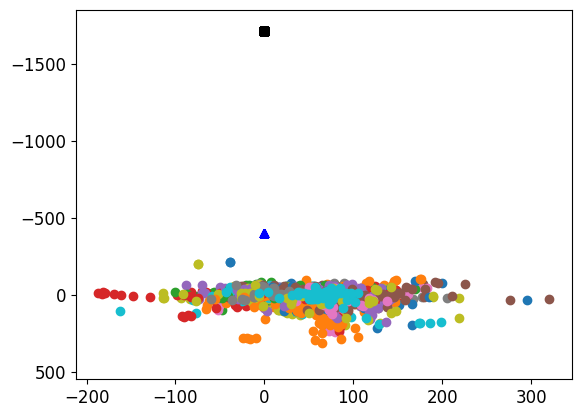

In [8]:
#Add extracellular stim
for c,metype in enumerate(sim.net.cells):
    if 'presyn' not in metype.tags['pop']:
        print("\n", metype.tags)
        plt.plot(0,-400,'b^')
        plt.plot(acs_params['position'][0],acs_params['position'][1],'ks')
        secList = [secs for secs in metype.secs.keys() if "pt3d" in metype.secs[secs]['geom']]
        plt.plot(np.array(getSecsPos(metype, secList)[0]),-1*np.array(getSecsPos(metype, secList)[1]),'o')
        # plt.ylim(2550,-1850)
        plt.ylim(550,-1850)
        # print(np.array(getSecsPos(cell, secList)[0]).mean(axis=-1),-1*np.array(getSecsPos(cell, secList)[1]).mean(axis=-1),np.array(getSecsPos(cell, secList)[2]).mean(axis=-1))

In [9]:
# sim.analysis.plotLFP(**{'plots': ['locations'], 
#         'figSize': (12,12), 
#         'saveData': False, 
#         'saveFig': False, 'showFig': False, 'dpi': 300})

# sim.analysis.plotLFP(**{'plots': ['timeSeries'], 
#         'electrodes': [0], #'avg', 
#         'timeRange': [350, cfg.duration], 
#         'figSize': (24,4), 'saveFig': False, 'showFig': False})

In [10]:
celltyp

'L1_SLAC_cNAC187_5'

In [11]:
# sim.analysis.plotShape(includePre=['L1_DAC_bNA'], includePost=['L1_DAC_bNA'], includeAxon=False, showSyns=False, showElectrodes=[0],
#     cvar= 'voltage', dist=0.6, elev=95, azim=-90, 
#     axisLabels=True, synStyle='o', 
#     clim= [-80, -60], showFig=False, synSize=2)
# sim.analysis.plotShape(includePre=['L1_DAC_bNA'], includePost=['L1_DAC_bNA'], includeAxon=True, showSyns=False, showElectrodes=False,
#     cvar= 'voltage', dist=0.6, elev=95, azim=-90, 
#     axisLabels=True, synStyle='o', 
#     clim= [-80, -60], showFig=False, synSize=2)

Plotting recorded cell traces ... trace


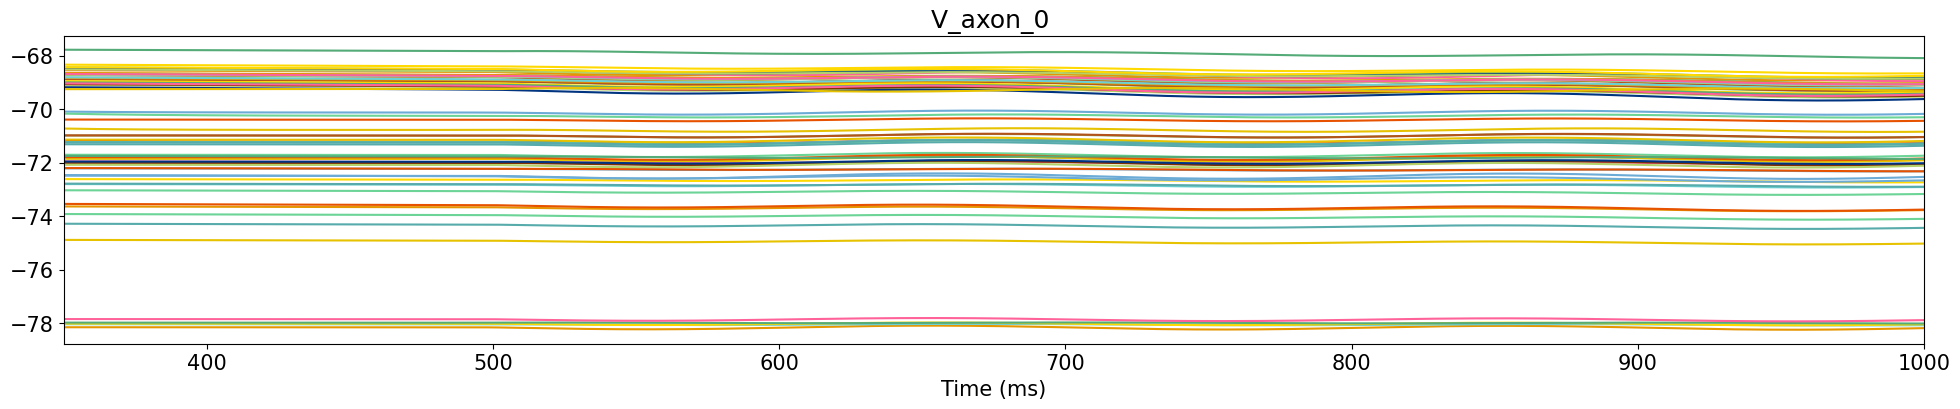

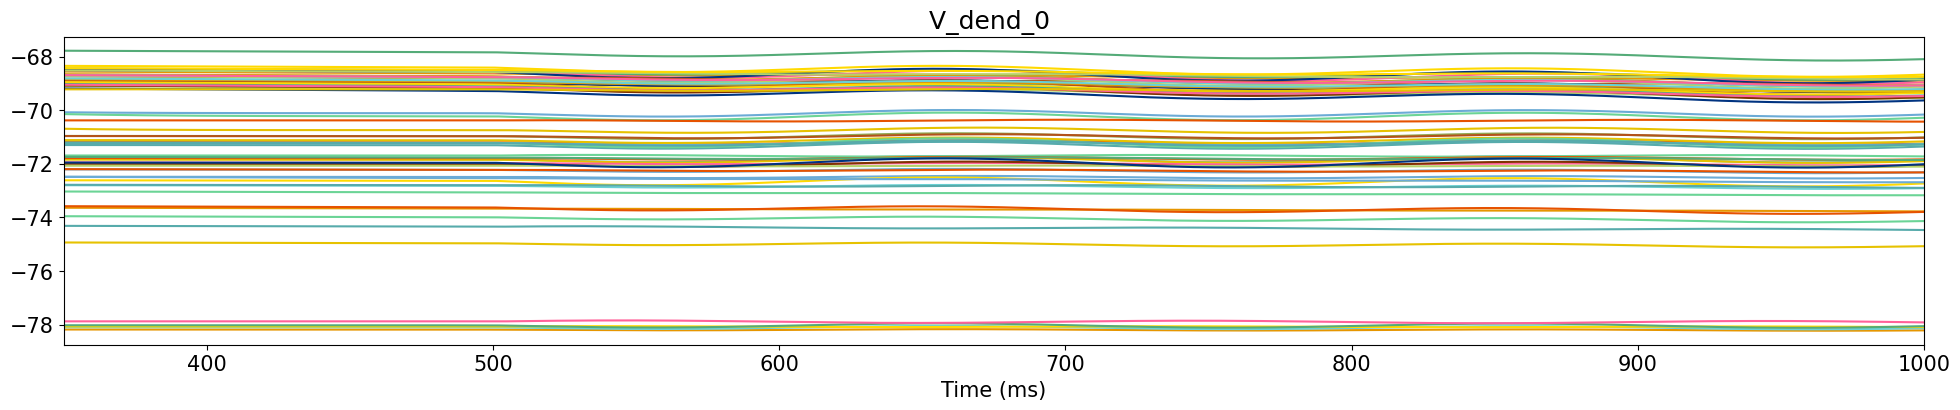

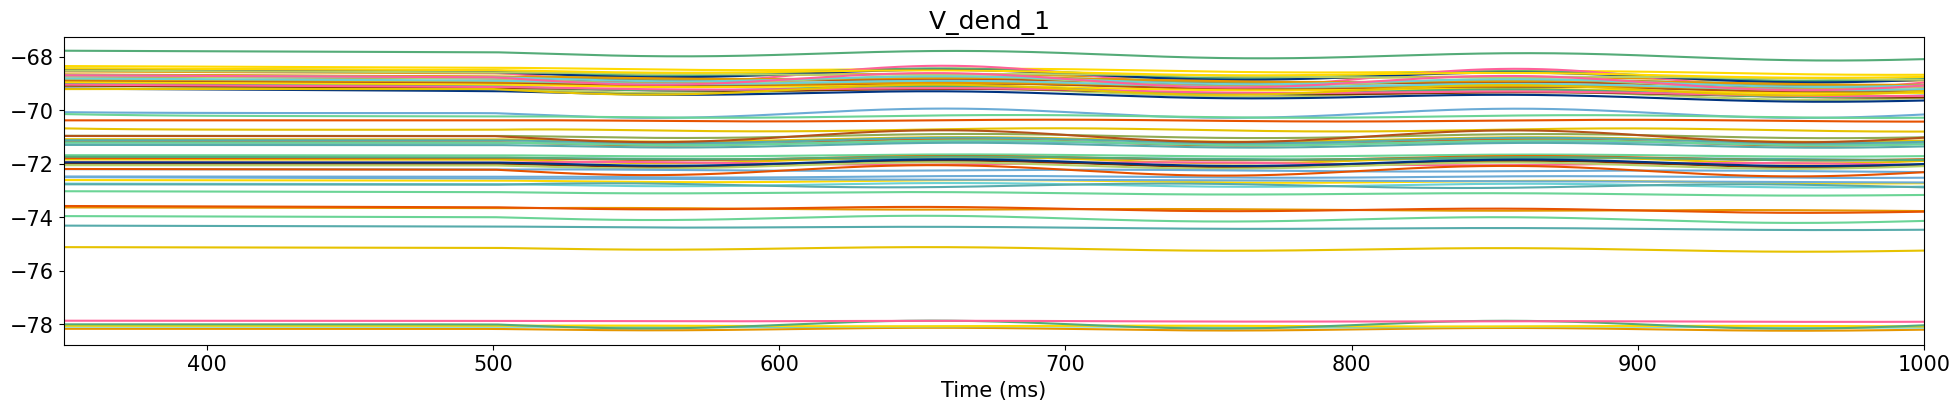

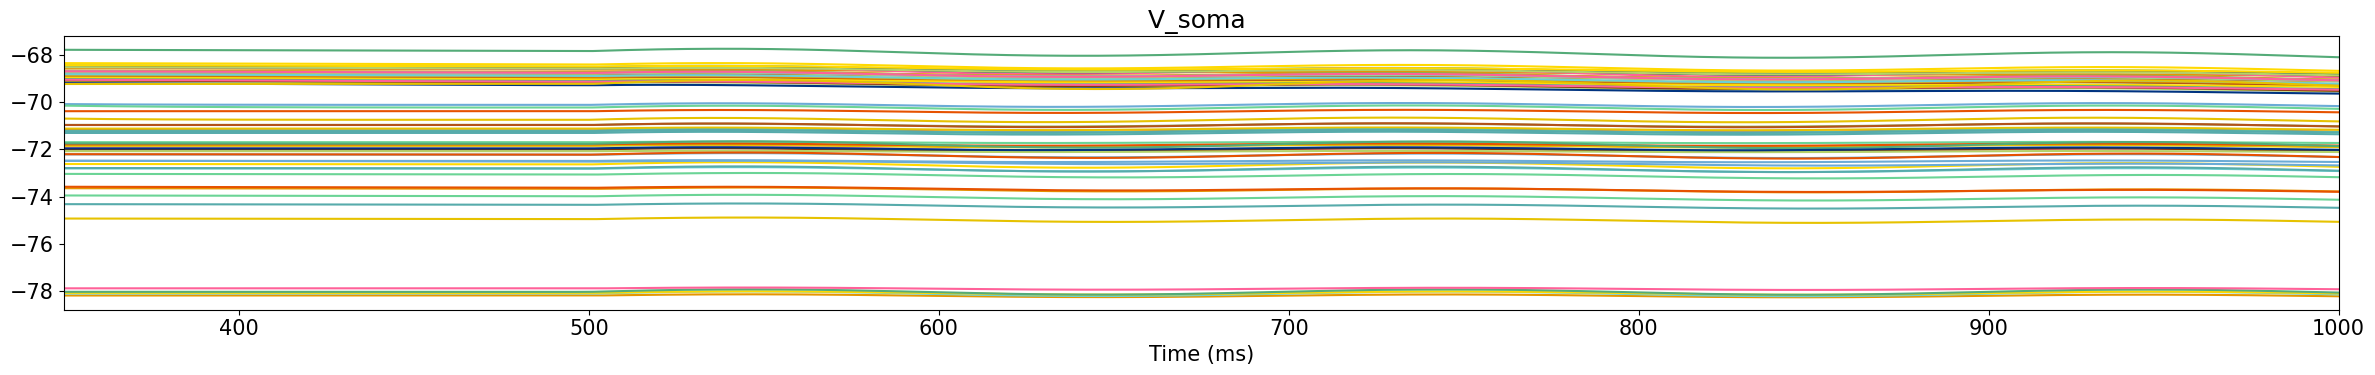

In [12]:
sim.analysis.plotTraces(overlay=True, timeRange = [350, cfg.duration], oneFigPer='trace', figSize=(24,4), fontSize=15, saveFig=False);

In [13]:
for section in netParams.cellParams[celltyp]['secLists']['axonal']:
    print(section,'->',netParams.cellParams[celltyp]['secs'][section]['topol']['parentSec'])

axon_0 -> soma
axon_1 -> axon_0


Plotting 2D representation of network cell locations and connections...


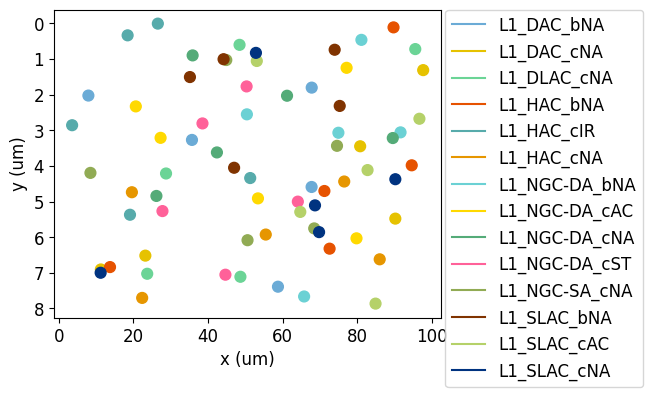

In [18]:
sim.analysis.plot2Dnet(figSize=(5, 4), fontSize=12);

In [26]:
# sim.analysis.plotRaster()

Preparing spike data...
No spikes available to plot raster
Plotting raster...

There was an exception in plotRaster()


Traceback (most recent call last):
  File "/home/fernando/miniconda3/envs/p38/lib/python3.8/site-packages/netpyne/analysis/utils.py", line 87, in wrapper
    return function(*args, **kwargs)
  File "/home/fernando/miniconda3/envs/p38/lib/python3.8/site-packages/netpyne/plotting/plotRaster.py", line 243, in plotRaster
    popNumCells = [max(spkInds)]
UnboundLocalError: local variable 'spkInds' referenced before assignment


Plotting recorded cell traces ... trace


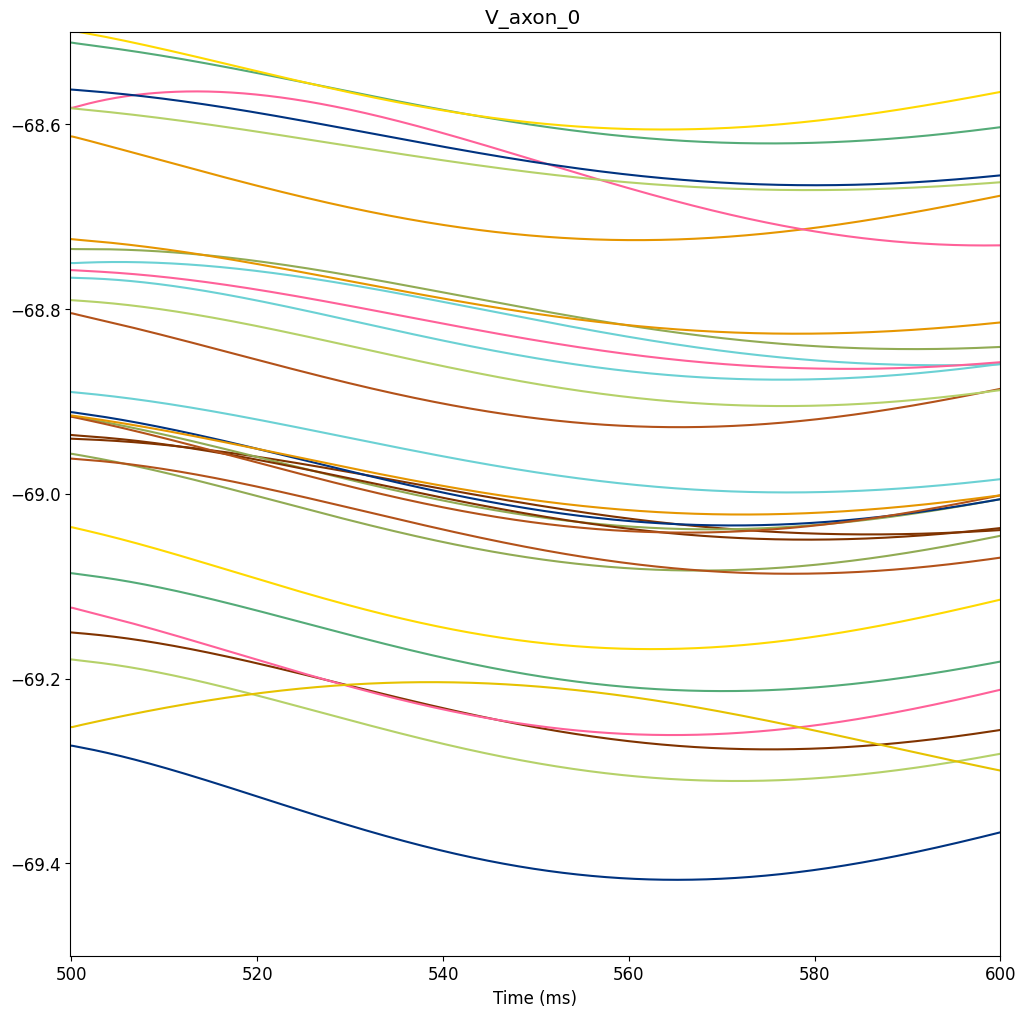

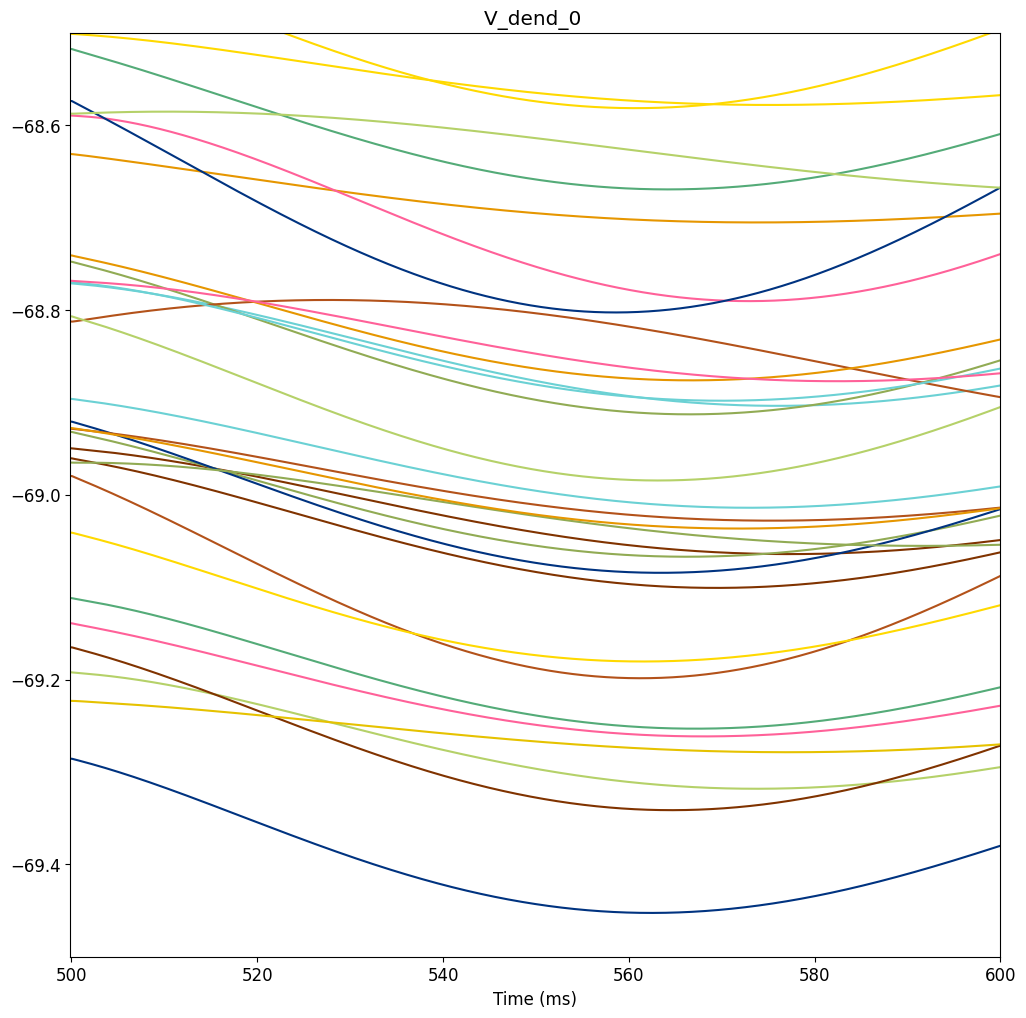

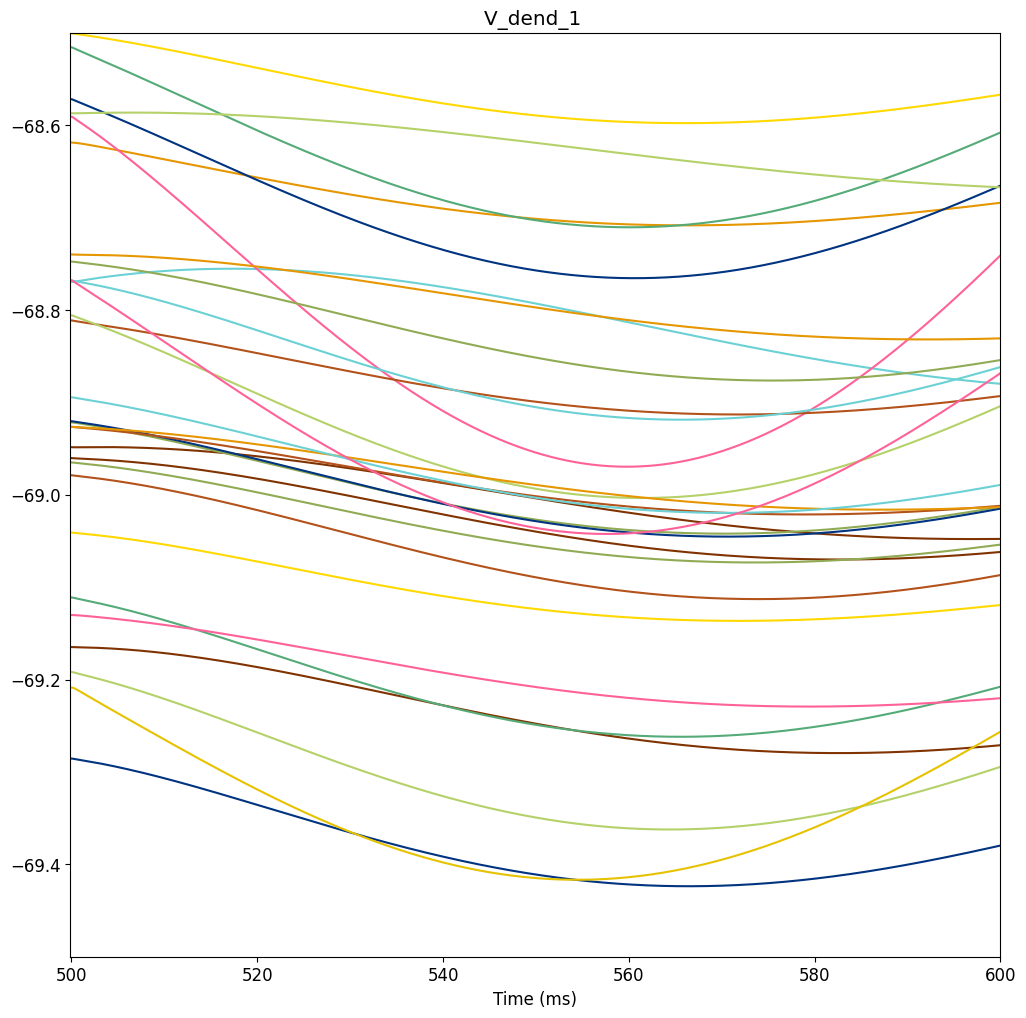

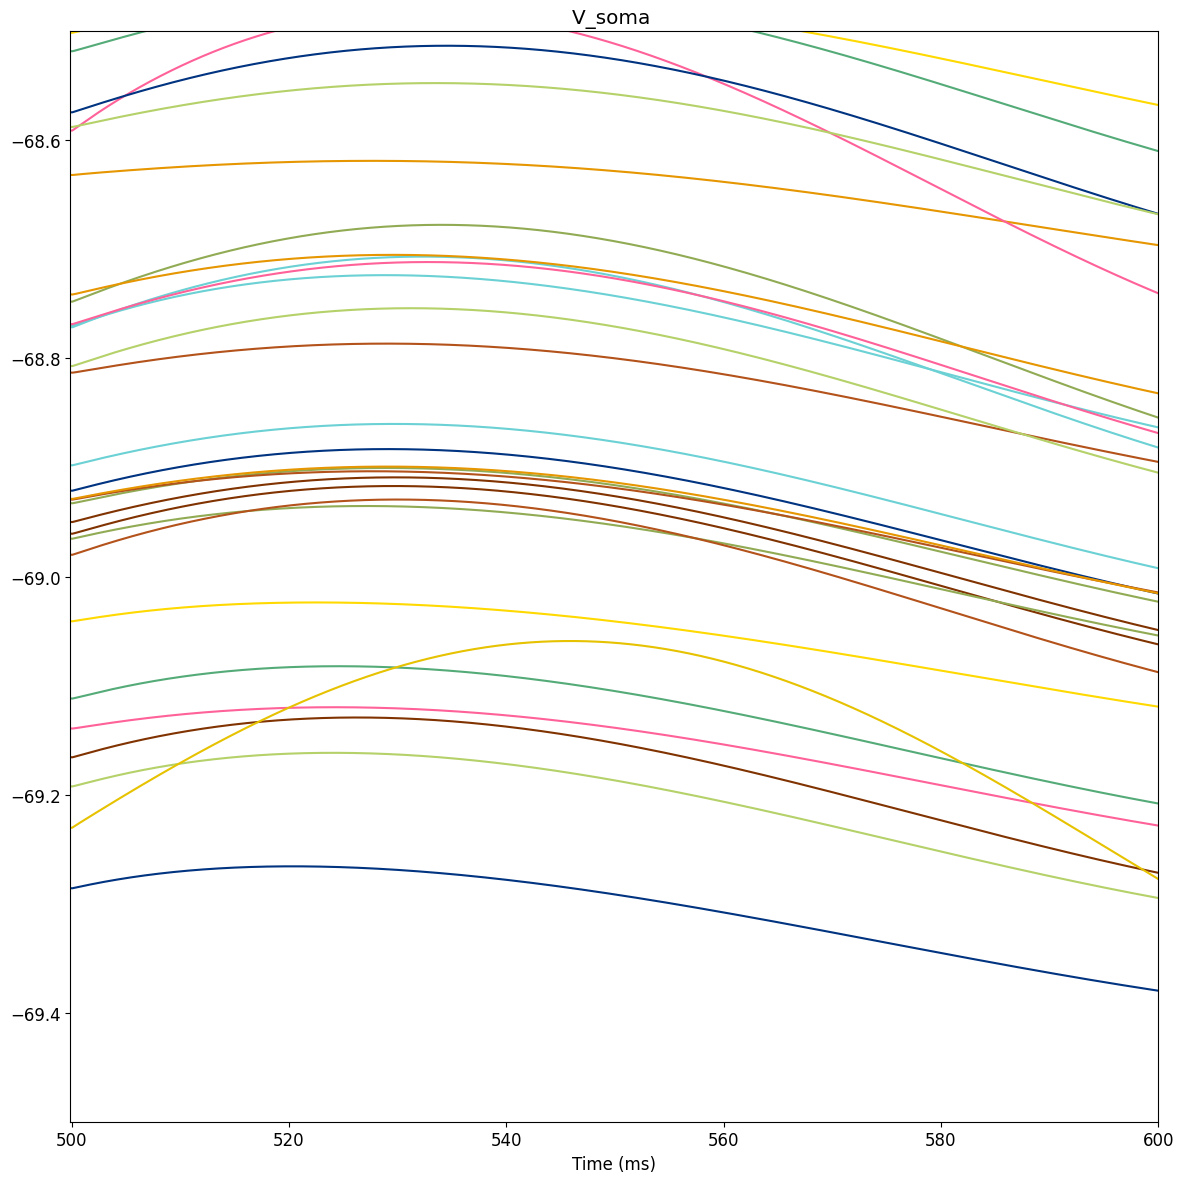

In [25]:
sim.analysis.plotTraces(overlay=True, ylim = [-69.5, -68.5], timeRange =[499.9, 600],  oneFigPer='trace', figSize=(12,12), fontSize=12, saveFig=False);